# Analyzing the Data of Top 200 songs on Spotify
## Amanuel Awoke
##  Ferzam Mohammad
## Josue Velasquez

# Introduction
## Motivation
The music industry has changed a lot in the last decade with the introduction of streaming services like Apple Music or Spotify. Services like Spotify allow users to livestream music for personal consumption, often for free or for a subscription fee. These services have made it easier to consume music and have increased opportunities for people to start producing music, but they have also changed how musicians make money. Whenever a user listens to a song on a streaming service, the service typically keeps track of the number of “plays” that song has. Music artists are then paid a small amount based on the number of plays they have accumulated for their music. Given how little these artists are paid from streaming services, maximizing the amount of revenue made from a song seems pretty valuable for those looking to push out music to these services. Play count also indicates where a song stands in the streaming services’ popularity lists, and making it onto their top 100 or 200 songs is a factor considered in whether these songs are added to global, official top songs charts i.e. Billboard 200.
 
Our group thought it would be interesting to see if we could try to make predictions for how popular a song might be given different features for a song (e.g. the genre of the song, how fast or slow it is, the key the song is written in, the time of year a song was released, how many listeners an artist already gets on average, etc.). If we can indicate how many plays a song will get, we can give a prediction for how much money a song will make on a streaming service. Much like the Moneyball scenario, it’s possible that artists are focusing on producing music that meets criteria which they think makes a song popular when, in reality, they should be focusing on other aspects of their music. Understanding what components of a song make it popular would help artists figure out the best way to produce music in order to make money off of these streaming services.

The Moneyball story demonstrated the importance of data science in producing a strong baseball team, and while music is different from sports, our project should hopefully reflect similar data science practices in order to reach a valuable conclusion. It may be relatively straightforward to look at aspects like which genres make the most money or whether a song by Taylor Swift will end up on the top 200 chart given her “incredibly loyal fanbase” of over 40 million people, but maybe there are other similarities between popular songs that could indicate factors which help make a song more popular. Data science practices like t-tests (maybe) or machine learning models help us here by giving us tools to help identify characteristics in a song, clarify how those characteristics might relate to play count, and predict what the play count (or popularity) for a similar song could be given factors that we have determined have an affect on play count (or popularity)
<One valuable conclusion might be the LACK OF money artists are being paid from streaming services, or how little they make off streaming services alone>


# Collect Data

This is the first step in the data lifecycle where we must identify information to web scrape. We gather data from the [Spotify Charts Regional Top 200](https://spotifycharts.com/regional) to first identify which songs had the highest stream counts in the United States, dating back to January 1st 2017, to current day. Spotify Charts provides tracks with the highest stream count, their top 200 rank, and the artist(s) who created that song. Spotify Charts already compiles the data into Excel tables, so it isn't necessary to directly scrape from the website. If you wanted to download one yourself, at the top right of the website, select a date you'd like to download in the dropdown, then select further up "Download to CSV." The pandas method read_csv() was used to process the Excel files into dataframes.



In [1]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import spotipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since there were consistent download URLs of Excel sheets in relation to the date they recorded, we used a looped to retreive the links then later download all sheets.

In [2]:
# Collect links from spotify charts top 200 streams per day
ref_str = "https://spotifycharts.com/regional/global/daily/"
ref_arr = []
# gets every day from janurary 2017 to October 2020

# for year in range(2017, 2021):
for year in range(2017, 2018):
    date = ""
    
    endingMonth = 12
    if year == 2020:
        endingMonth = 10
        
    # for month in range (1, endingMonth + 1):
    for month in range (1,13):
       
        dayCount = -1

        #gets proper day count per month
        thirtyDayCountMonths = [4, 6, 9, 11]
        if month == 2:
            dayCount = 29
        elif month in thirtyDayCountMonths:
            dayCount = 30
        else:
            dayCount = 31

        if int(month) < 10:
            month = "0" + str(month)
        # for day in range (1, daycount + 1):
        #for day in range (1, 16):
           
        #if int(day) < 10:
        #    day = "0" + str(day)

        date = str(year) + "-" + str(month) + "-" + "01" + "/download"
        date = ref_str + date
        ref_arr.append(date)

ref_arr

['https://spotifycharts.com/regional/global/daily/2017-01-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-02-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-03-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-04-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-05-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-06-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-07-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-08-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-09-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-10-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-11-01/download',
 'https://spotifycharts.com/regional/global/daily/2017-12-01/download']

In [3]:
#Loop downloading and appending of dataframes 

df = pd.DataFrame(columns =['position', 'track_name', 'artist', 'streams', 'url', 'date'] )
#make dir to save to
path = "sheets"
folderExists = False
try:
    os.mkdir(path)
except FileExistsError:
    print ("Folder already exists")
    folderExists = True

for i in ref_arr:

    r = requests.get(i, allow_redirects = True)
    #String manipulation to read from the correct csv files
    date = i[48:58]
    fileName = "regional-global-daily-" + date + ".csv"
    if not folderExists:
        print("Downloading... " + fileName)
        open(fileName, "wb").write(r.content)

        os.rename(fileName, "sheets/" + fileName)

    df_new = pd.read_csv(path + "/" + fileName)
    df_new.columns= ['position', 'track_name', 'artist', 'streams', 'url']
    df_new['date'] = date
    
    df_new = df_new.iloc[1:] #deletes junk row from csv conversion
    df = df.append(df_new)

print("Done")
df = df.reset_index() # Sets index back to being the regular 0-based index. This is really helpful when trying to add more to the dataframe later, because otherwise there are lots of duplicate indices
df['streams'] = df['streams'].astype(int) #streams are a string of a num, must wrap as type int always

Folder already exists
Done


## Wrangled data into dataframe

In [4]:
df

,index,position,track_name,artist,streams,url,date
0,1,1,Starboy,The Weeknd,3135625,https://open.spotify.com/track/5aAx2yezTd8zXrk...,2017-01-01
1,2,2,Closer,The Chainsmokers,3015525,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,2017-01-01
2,3,3,Let Me Love You,DJ Snake,2545384,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,2017-01-01
3,4,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-01-01
4,5,5,One Dance,Drake,2259887,https://open.spotify.com/track/1xznGGDReH1oQq0...,2017-01-01
...,...,...,...,...,...,...,...
2395,196,196,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,552118,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-12-01
2396,197,197,Rake It Up (feat. Nicki Minaj),Yo Gotti,551576,https://open.spotify.com/track/4knL4iPxPOZjQzT...,2017-12-01
2397,198,198,New Freezer (feat. Kendrick Lamar),Rich The Kid,550167,https://open.spotify.com/track/4pYZLpX23Vx8rwD...,2017-12-01
2398,199,199,All Night,Steve Aoki,548039,https://open.spotify.com/track/5mAxA6Q1SIym6dP...,2017-12-01


# Data Processing

[Spotipy](https://spotipy.readthedocs.io/en/2.16.1/#) is a lightweight Python library for the [Spotify Web API](https://developer.spotify.com/documentation/web-api/) used to retrieve more detailed data for tracks now that their names have been retrieved from the Spotify Top 200. We must first authenticate our usage of the API.

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials


SPOTIPY_CLIENT_ID="ea1a162fbc6f413990542b76ab82a168"
SPOTIPY_CLIENT_SECRET="a09882042ce54f158fdd2b6baaf2b26d"
SPOTIPY_CLIENT_REDIRECT="http://www.cs.umd.edu/class/fall2020/cmsc320-0201/"

scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_CLIENT_REDIRECT))



We're going to start by using the Spotify API to get more information about all the tracks we found in the top 200's chart for the timeframe we described above. The Spotify API gives us the ability to get "audio features" from a song given a song id that Spotify creates for every track. These "audio features" include characteristics like loudness, positivity, danceability, how energetic the song is, the speed of the song, and a couple other similar characteristics that have been determined by Spotify using their own machine learning algorithms.

First, we do need to get an id for every song and artist in our dataframe to be able to make queries through the Spotify API for a specific track or artist. Here, we get track and artist ids, and we also make a query for the audio features of each track id. We're doing these together for code efficiency, just because a large number of queries through the Spotify API can take time.

In [55]:
import time
import xlsxwriter
import openpyxl

#open time counter
artist_id_list = []
track_id_list = []
audio_features_df = pd.DataFrame()
tic = time.perf_counter()

#if cached df exists dont search again, else search again
if not os.path.exists("cached_df.xlsx"):
    #Take each song and lookup its audio features, then create a dataframe for them
    print("Searching...")
    for index, row in df.iterrows():
        trackName = row['track_name']
        track_id = ""
        artist_id = ""
        #print(trackName)
        # We need to check if our track_name received was a nan value. Idk how these got in here, but there are nans
        if(type(trackName) == str):
            trackNameWithoutSpaces = '+'.join(trackName.split())
            searchQuery = sp.search(trackNameWithoutSpaces, 1, 0)
            #print(searchQuery)
            if (len(searchQuery['tracks']['items']) != 0):
                track_object = searchQuery['tracks']['items'][0]
                #print(track_object)
                artist_object = track_object['artists'][0] if type(track_object['artists']) is list else track_object['artists']
                artist_id = artist_object['id']
                track_id = track_object['id']
                #print(track_id)
                artist_id_list.append(artist_id)
                track_id_list.append(track_id)

             # If our query returned nothing then append a nan in the place of artist and track for this entry
            else:
                artist_id_list.append(np.nan)
                track_id_list.append(np.nan)
        # If we had stored a nan, then just plan to append a nan in this position
        else:
            artist_id_list.append(np.nan)
            track_id_list.append(np.nan)
            
        audiofeatures = {'duration_ms' : np.nan, 'key' : np.nan, 'mode' : np.nan, 'time_signature' : np.nan, 'acousticness' : np.nan, 'danceability' : np.nan, 'energy' : np.nan, 'instrumentalness' : np.nan, 'liveness' : np.nan, 'loudness' : np.nan, 'speechiness' : np.nan, 'valence' : np.nan, 'tempo' : np.nan, 'id' : np.nan, 'uri' : np.nan, 'track_href' : np.nan, 'analysis_url' : np.nan, 'type' : np.nan, }
        # If we successfully found a track when we did our seach, then get the audio features for that
        #print(track_id)
        if (track_id != ""):
            audiofeatures = sp.audio_features(track_id)[0]

        audio_features_df = audio_features_df.append(audiofeatures, ignore_index=True)
    audio_features_df['artist_id'] = artist_id_list#needed for dimensions
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter('cached_df.xlsx', engine='openpyxl')

    # Convert the dataframe to an XlsxWriter Excel object.
    audio_features_df.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()
    toc = time.perf_counter()
    print(f"Searches took {toc - tic:0.4f} mf seconds damn")
    
else: #access the cached
 
    print("Cached dataframe found.")
    audio_features_df = pd.read_excel("cached_df.xlsx", engine = "openpyxl")
    audio_features_df.drop(["Unnamed: 0"], axis=1, inplace=True) #delete position row since rank alraedy has this information
audio_features_df

Searching...
Searches took 467.0723 mf seconds damn


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,artist_id
0,0.14100,https://api.spotify.com/v1/audio-analysis/7MXV...,0.679,230453.0,0.587,7MXVkk9YMctZqd1Srtv4MB,0.000006,7.0,0.137,-7.015,1.0,0.2760,186.003,4.0,https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...,audio_features,spotify:track:7MXVkk9YMctZqd1Srtv4MB,0.486,1Xyo4u8uXC1ZmMpatF05PJ
1,0.41400,https://api.spotify.com/v1/audio-analysis/7BKL...,0.748,244960.0,0.524,7BKLCZ1jbUBVqRi2FVlTVw,0.000000,8.0,0.111,-5.599,1.0,0.0338,95.010,4.0,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,audio_features,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,0.661,69GGBxA162lTqCwzJG5jLp
2,0.23500,https://api.spotify.com/v1/audio-analysis/3ibK...,0.656,256733.0,0.578,3ibKnFDaa3GhpPGlOUj7ff,0.000000,7.0,0.118,-8.970,0.0,0.0922,94.514,4.0,https://api.spotify.com/v1/tracks/3ibKnFDaa3Gh...,audio_features,spotify:track:3ibKnFDaa3GhpPGlOUj7ff,0.556,20s0P9QLxGqKuCsGwFsp7w
3,0.40600,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,251088.0,0.763,5knuzwU65gJK7IF5yJsuaW,0.000000,9.0,0.180,-4.068,0.0,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.742,6MDME20pz9RveH9rEXvrOM
4,0.00776,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987.0,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001800,1.0,0.329,-5.609,1.0,0.0536,103.967,4.0,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370,3TVXtAsR1Inumwj472S9r4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.40600,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,251088.0,0.763,5knuzwU65gJK7IF5yJsuaW,0.000000,9.0,0.180,-4.068,0.0,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.742,6MDME20pz9RveH9rEXvrOM
2396,0.02200,https://api.spotify.com/v1/audio-analysis/4knL...,0.910,276333.0,0.444,4knL4iPxPOZjQzTUlELGSY,0.000000,1.0,0.137,-8.126,0.0,0.3440,149.953,4.0,https://api.spotify.com/v1/tracks/4knL4iPxPOZj...,audio_features,spotify:track:4knL4iPxPOZjQzTUlELGSY,0.530,6Ha4aES39QiVjR0L2lwuwq
2397,0.04050,https://api.spotify.com/v1/audio-analysis/2EgB...,0.884,191938.0,0.698,2EgB4n6XyBsuNUbuarr4eG,0.000000,0.0,0.195,-9.101,1.0,0.3640,140.068,4.0,https://api.spotify.com/v1/tracks/2EgB4n6XyBsu...,audio_features,spotify:track:2EgB4n6XyBsuNUbuarr4eG,0.575,1pPmIToKXyGdsCF6LmqLmI
2398,0.00410,https://api.spotify.com/v1/audio-analysis/0dXN...,0.538,197640.0,0.804,0dXNQ8dckG4eYfEtq9zcva,0.000000,8.0,0.330,-5.194,1.0,0.0358,144.992,4.0,https://api.spotify.com/v1/tracks/0dXNQ8dckG4e...,audio_features,spotify:track:0dXNQ8dckG4eYfEtq9zcva,0.507,7gAppWoH7pcYmphCVTXkzs


In [56]:
#print(artist_id_list)
#audio_features_df['artist_id'] = artist_id_list
audio_features_df


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,artist_id
0,0.14100,https://api.spotify.com/v1/audio-analysis/7MXV...,0.679,230453.0,0.587,7MXVkk9YMctZqd1Srtv4MB,0.000006,7.0,0.137,-7.015,1.0,0.2760,186.003,4.0,https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...,audio_features,spotify:track:7MXVkk9YMctZqd1Srtv4MB,0.486,1Xyo4u8uXC1ZmMpatF05PJ
1,0.41400,https://api.spotify.com/v1/audio-analysis/7BKL...,0.748,244960.0,0.524,7BKLCZ1jbUBVqRi2FVlTVw,0.000000,8.0,0.111,-5.599,1.0,0.0338,95.010,4.0,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,audio_features,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,0.661,69GGBxA162lTqCwzJG5jLp
2,0.23500,https://api.spotify.com/v1/audio-analysis/3ibK...,0.656,256733.0,0.578,3ibKnFDaa3GhpPGlOUj7ff,0.000000,7.0,0.118,-8.970,0.0,0.0922,94.514,4.0,https://api.spotify.com/v1/tracks/3ibKnFDaa3Gh...,audio_features,spotify:track:3ibKnFDaa3GhpPGlOUj7ff,0.556,20s0P9QLxGqKuCsGwFsp7w
3,0.40600,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,251088.0,0.763,5knuzwU65gJK7IF5yJsuaW,0.000000,9.0,0.180,-4.068,0.0,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.742,6MDME20pz9RveH9rEXvrOM
4,0.00776,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987.0,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001800,1.0,0.329,-5.609,1.0,0.0536,103.967,4.0,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370,3TVXtAsR1Inumwj472S9r4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.40600,https://api.spotify.com/v1/audio-analysis/5knu...,0.720,251088.0,0.763,5knuzwU65gJK7IF5yJsuaW,0.000000,9.0,0.180,-4.068,0.0,0.0523,101.965,4.0,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,audio_features,spotify:track:5knuzwU65gJK7IF5yJsuaW,0.742,6MDME20pz9RveH9rEXvrOM
2396,0.02200,https://api.spotify.com/v1/audio-analysis/4knL...,0.910,276333.0,0.444,4knL4iPxPOZjQzTUlELGSY,0.000000,1.0,0.137,-8.126,0.0,0.3440,149.953,4.0,https://api.spotify.com/v1/tracks/4knL4iPxPOZj...,audio_features,spotify:track:4knL4iPxPOZjQzTUlELGSY,0.530,6Ha4aES39QiVjR0L2lwuwq
2397,0.04050,https://api.spotify.com/v1/audio-analysis/2EgB...,0.884,191938.0,0.698,2EgB4n6XyBsuNUbuarr4eG,0.000000,0.0,0.195,-9.101,1.0,0.3640,140.068,4.0,https://api.spotify.com/v1/tracks/2EgB4n6XyBsu...,audio_features,spotify:track:2EgB4n6XyBsuNUbuarr4eG,0.575,1pPmIToKXyGdsCF6LmqLmI
2398,0.00410,https://api.spotify.com/v1/audio-analysis/0dXN...,0.538,197640.0,0.804,0dXNQ8dckG4eYfEtq9zcva,0.000000,8.0,0.330,-5.194,1.0,0.0358,144.992,4.0,https://api.spotify.com/v1/tracks/0dXNQ8dckG4e...,audio_features,spotify:track:0dXNQ8dckG4eYfEtq9zcva,0.507,7gAppWoH7pcYmphCVTXkzs


In [57]:

#Append audio features to master dataframe
audio_features_df
df['track_id'] = audio_features_df['id']
df['duration_ms'] = audio_features_df['duration_ms']
df['acousticness'] = audio_features_df['acousticness']
df['danceability'] = audio_features_df['danceability']
df['energy'] = audio_features_df['energy']
df['instrumentalness'] = audio_features_df['instrumentalness']
df['liveness'] = audio_features_df['liveness']
df['loudness'] = audio_features_df['loudness']
df['speechiness'] = audio_features_df['speechiness']
df['valence'] = audio_features_df['valence']
df['tempo'] = audio_features_df['tempo']
df['artist_id'] = audio_features_df['artist_id']

df

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
0,1,1,Starboy,The Weeknd,3135625.0,https://open.spotify.com/track/5aAx2yezTd8zXrk...,2017-01-01,7MXVkk9YMctZqd1Srtv4MB,230453.0,0.14100,0.679,0.587,0.000006,0.137,-7.015,0.2760,0.486,186.003,1Xyo4u8uXC1ZmMpatF05PJ
1,2,2,Closer,The Chainsmokers,3015525.0,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,2017-01-01,7BKLCZ1jbUBVqRi2FVlTVw,244960.0,0.41400,0.748,0.524,0.000000,0.111,-5.599,0.0338,0.661,95.010,69GGBxA162lTqCwzJG5jLp
2,3,3,Let Me Love You,DJ Snake,2545384.0,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,2017-01-01,3ibKnFDaa3GhpPGlOUj7ff,256733.0,0.23500,0.656,0.578,0.000000,0.118,-8.970,0.0922,0.556,94.514,20s0P9QLxGqKuCsGwFsp7w
3,4,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604.0,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-01-01,5knuzwU65gJK7IF5yJsuaW,251088.0,0.40600,0.720,0.763,0.000000,0.180,-4.068,0.0523,0.742,101.965,6MDME20pz9RveH9rEXvrOM
4,5,5,One Dance,Drake,2259887.0,https://open.spotify.com/track/1xznGGDReH1oQq0...,2017-01-01,1zi7xx7UVEFkmKfv06H8x0,173987.0,0.00776,0.792,0.625,0.001800,0.329,-5.609,0.0536,0.370,103.967,3TVXtAsR1Inumwj472S9r4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,196,196,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,552118.0,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-12-01,5knuzwU65gJK7IF5yJsuaW,251088.0,0.40600,0.720,0.763,0.000000,0.180,-4.068,0.0523,0.742,101.965,6MDME20pz9RveH9rEXvrOM
2396,197,197,Rake It Up (feat. Nicki Minaj),Yo Gotti,551576.0,https://open.spotify.com/track/4knL4iPxPOZjQzT...,2017-12-01,4knL4iPxPOZjQzTUlELGSY,276333.0,0.02200,0.910,0.444,0.000000,0.137,-8.126,0.3440,0.530,149.953,6Ha4aES39QiVjR0L2lwuwq
2397,198,198,New Freezer (feat. Kendrick Lamar),Rich The Kid,550167.0,https://open.spotify.com/track/4pYZLpX23Vx8rwD...,2017-12-01,2EgB4n6XyBsuNUbuarr4eG,191938.0,0.04050,0.884,0.698,0.000000,0.195,-9.101,0.3640,0.575,140.068,1pPmIToKXyGdsCF6LmqLmI
2398,199,199,All Night,Steve Aoki,548039.0,https://open.spotify.com/track/5mAxA6Q1SIym6dP...,2017-12-01,0dXNQ8dckG4eYfEtq9zcva,197640.0,0.00410,0.538,0.804,0.000000,0.330,-5.194,0.0358,0.507,144.992,7gAppWoH7pcYmphCVTXkzs


In [58]:
#visualization
#plotting all the new metrics in our dataframe vs streams
df['streams'] = df['streams'].astype(float)
df['position'] = df['position'].astype(int)
df.loc[df['position'] == 1].head(10) # Previously this was showing that every 

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
0,1,1,Starboy,The Weeknd,3135625.0,https://open.spotify.com/track/5aAx2yezTd8zXrk...,2017-01-01,7MXVkk9YMctZqd1Srtv4MB,230453.0,0.1410,0.679,0.587,0.000006,0.1370,-7.015,0.2760,0.486,186.003,1Xyo4u8uXC1ZmMpatF05PJ
200,1,1,Shape of You,Ed Sheeran,7549041.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-02-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.5810,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
400,1,1,Shape of You,Ed Sheeran,7201132.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-03-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.5810,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
600,1,1,Shape of You,Ed Sheeran,6815498.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-04-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.5810,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
800,1,1,Despacito - Remix,Luis Fonsi,6360737.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-05-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.2280,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
1000,1,1,Despacito - Remix,Luis Fonsi,7332260.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-06-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.2280,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
1200,1,1,Despacito - Remix,Luis Fonsi,6398530.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-07-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.2280,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
1400,1,1,Mi Gente,J Balvin,4529147.0,https://open.spotify.com/track/2rb5MvYT7ZIxbKW...,2017-08-01,4ipnJyDU3Lq15qBAYNqlqK,189440.0,0.0179,0.774,0.687,0.000012,0.1280,-4.818,0.0584,0.308,104.959,1vyhD5VmyZ7KMfW5gqLgo5
1600,1,1,Look What You Made Me Do,Taylor Swift,5547962.0,https://open.spotify.com/track/6uFsE1JgZ20EXyU...,2017-09-01,1P17dC1amhFzptugyAO7Il,211853.0,0.2040,0.766,0.709,0.000014,0.1260,-6.471,0.1230,0.506,128.070,06HL4z0CvFAxyc27GXpf02
1800,1,1,rockstar,Post Malone,5649503.0,https://open.spotify.com/track/1OmcAT5Y8eg5bUP...,2017-10-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.2470,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk


# Data Visualization

We've now gathered the 

[1036635.86, 1024704.14, 921231.93, 1068242.56, 938942.38, 1217917.22, 999340.22, 1170673.39, 1079798.17, 1137195.66, 980583.6, 1062601.65, 1044284.96, 1145475.5, 954185.2, 1026515.49, 1056313.86, 967448.54, 1022967.39, 1081935.98, 1034133.38, 1026983.27, 1087787.58, 959457.05, 989671.1, 1087260.49, 1131004.44, 1054427.49, 1141422.84, 1079745.99, 953697.66, 965382.01, 1154213.72, 1022490.27, 1137368.73, 924950.12, 1170345.87, 988449.8, 1086246.95, 1062377.65, 992564.43, 1116418.32, 923051.55, 1105206.81, 967274.76, 945603.77, 942743.02, 1033700.52, 958188.85, 1008201.96, 981451.04, 1087860.19, 1201424.2, 937142.41, 878957.75, 1033776.1, 995898.81, 1109691.28, 899398.52, 1045721.34, 1071625.55, 1054374.3, 998933.87, 1085164.32, 964838.61, 1072987.98, 983417.79, 859572.44, 966598.49, 1030420.11, 978436.84, 967151.06, 931905.28, 1000084.63, 1066327.31, 1028588.6, 947415.03, 882349.35, 952269.7, 951685.11, 897206.86, 999076.88, 931573.6, 1188852.86, 999307.77, 1105427.29, 1036058.66, 10199

Text(0, 0.5, 'Frequency')

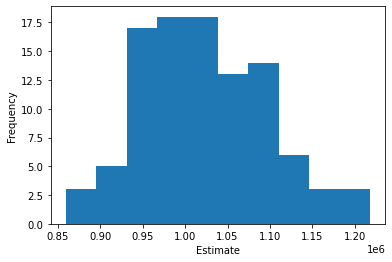

In [59]:
#Histogram takes 100 random tracks, takes the average of all their streams, then does this 100 times
#Is a standarrd deviation


from scipy.stats import normaltest
from numpy.random import seed
from numpy.random import randn


alpha = 0.05
#data = df['tempo'].sample(n=10).array
data = []
for i in range(0,100):
    data.append(np.mean(df['streams'].sample(n=100)))
print(data)
plt.hist(data)
plt.xlabel("Estimate")
plt.ylabel("Frequency")


In [60]:
from sklearn import linear_model

#Get averages of each col
duration_mean = np.mean(df['duration_ms'])
acousticness_mean = np.mean(df['acousticness'])
danceability_mean = np.mean(df['danceability'])
energy_mean = np.mean(df['energy'])
instrumentalness_mean = np.mean(df['instrumentalness'])
liveness_mean = np.mean(df['liveness'])
loudness_mean = np.mean(df['loudness'])
speechiness_mean = np.mean(df['speechiness'])
valence_mean = np.mean(df['valence'])
tempo_mean = np.mean(df['tempo'])

print(duration_mean)

218169.1349137931


Text(0, 0.5, 'streams in millions')

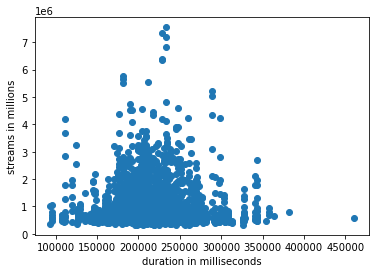

In [61]:
plt.scatter(df['duration_ms'], df['streams'])
plt.xlabel('duration in milliseconds')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

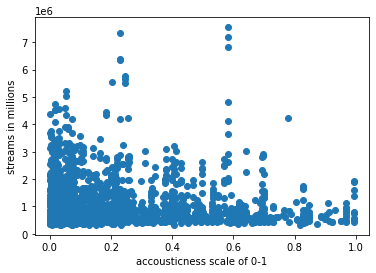

In [62]:
plt.scatter(df['acousticness'],df['streams'])
plt.xlabel('accousticness scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

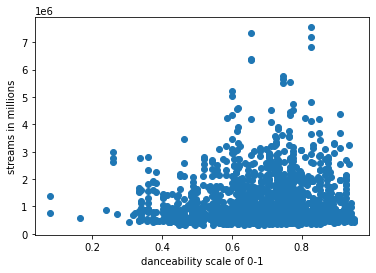

In [63]:
plt.scatter(df['danceability'],df['streams'])
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

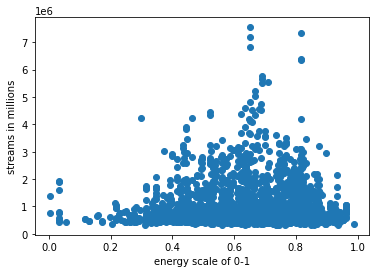

In [64]:
plt.scatter(df['energy'],df['streams'])
plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

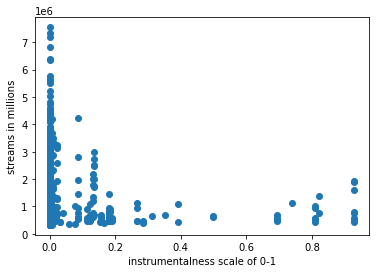

In [65]:
plt.scatter(df['instrumentalness'],df['streams'])
plt.xlabel('instrumentalness scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

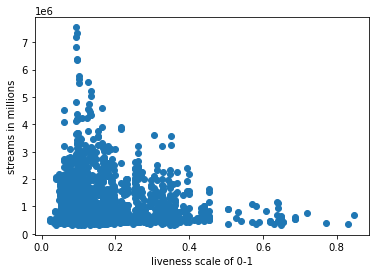

In [66]:
plt.scatter(df['liveness'],df['streams'])
plt.xlabel('liveness scale of 0-1') 
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

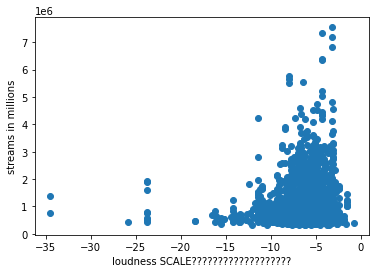

In [67]:
plt.scatter(df['loudness'],df['streams'])
plt.xlabel('loudness SCALE???????????????????')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

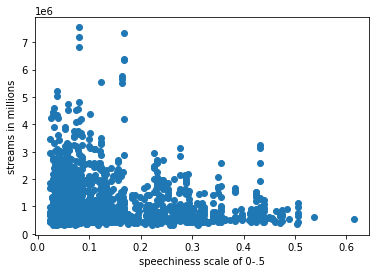

In [68]:
plt.scatter(df['speechiness'],df['streams'])
plt.xlabel('speechiness scale of 0-.5')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

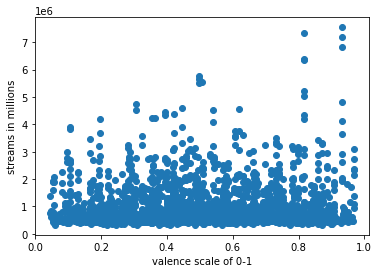

In [69]:
plt.scatter(df['valence'],df['streams'])
plt.xlabel('valence scale of 0-1')
plt.ylabel('streams in millions')

Text(0, 0.5, 'streams in millions')

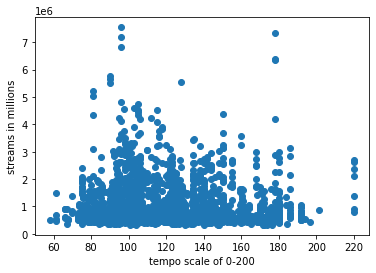

In [70]:
plt.scatter(df['tempo'],df['streams'])
plt.xlabel('tempo scale of 0-200')
plt.ylabel('streams in millions')

In [71]:
#violin plot of genre vs streams in millions
# ax = sns.violinplot(x='genre', y='streams', data=df, palette='muted')


Text(0, 0.5, 'streams in millions')

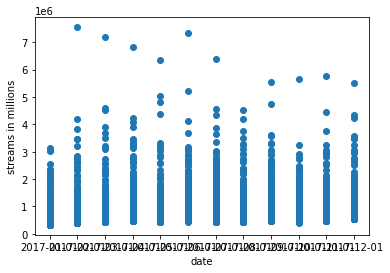

In [72]:
plt.scatter(df['date'],df['streams'])
plt.xlabel('date')
plt.ylabel('streams in millions')

# Insight
Does popularity/followers make a difference?

In [73]:
top5s = df.loc[df['position'] <= 5]
top5s.head()

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
0,1,1,Starboy,The Weeknd,3135625.0,https://open.spotify.com/track/5aAx2yezTd8zXrk...,2017-01-01,7MXVkk9YMctZqd1Srtv4MB,230453.0,0.14100,0.679,0.587,0.000006,0.137,-7.015,0.2760,0.486,186.003,1Xyo4u8uXC1ZmMpatF05PJ
1,2,2,Closer,The Chainsmokers,3015525.0,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,2017-01-01,7BKLCZ1jbUBVqRi2FVlTVw,244960.0,0.41400,0.748,0.524,0.000000,0.111,-5.599,0.0338,0.661,95.010,69GGBxA162lTqCwzJG5jLp
2,3,3,Let Me Love You,DJ Snake,2545384.0,https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,2017-01-01,3ibKnFDaa3GhpPGlOUj7ff,256733.0,0.23500,0.656,0.578,0.000000,0.118,-8.970,0.0922,0.556,94.514,20s0P9QLxGqKuCsGwFsp7w
3,4,4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,2356604.0,https://open.spotify.com/track/5knuzwU65gJK7IF...,2017-01-01,5knuzwU65gJK7IF5yJsuaW,251088.0,0.40600,0.720,0.763,0.000000,0.180,-4.068,0.0523,0.742,101.965,6MDME20pz9RveH9rEXvrOM
4,5,5,One Dance,Drake,2259887.0,https://open.spotify.com/track/1xznGGDReH1oQq0...,2017-01-01,1zi7xx7UVEFkmKfv06H8x0,173987.0,0.00776,0.792,0.625,0.001800,0.329,-5.609,0.0536,0.370,103.967,3TVXtAsR1Inumwj472S9r4


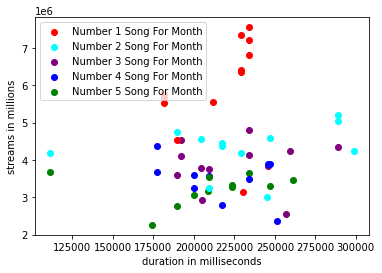

In [74]:
color_list = ['r', 'cyan', 'purple', 'b', 'green']

i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['duration_ms'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('duration in milliseconds')
plt.ylabel('streams in millions')
plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])


This graph Shows how the duration of a song in milliseconds compares to the number of streams that song received, and we're only using the first 10 pieces of data from our dataframe. This shows us that the songs with the most streams from this set of data are songs which are > 240000 ms, or 4 minutes. This is surprising, because the average song is usually around 3 minutes and 30 seconds or less.

Text(0, 0.5, 'streams in millions')

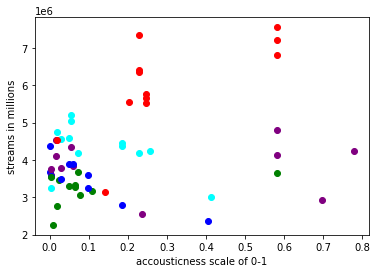

In [75]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['acousticness'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('accousticness scale of 0-1')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph displays a confidence score for how likely it is that a song is acoustic (with a value of 1 being very likely that the song is acoustic) compared to the number of streams the song has. All of the confidence scores are less than .5, which indicates most of these songs are probably not acoustic

Text(0, 0.5, 'streams in millions')

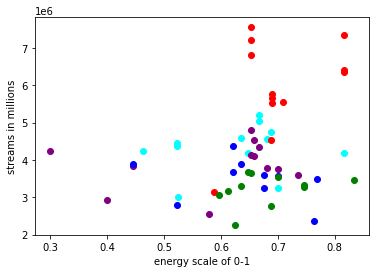

In [76]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['energy'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph shows how the "energy" of a song, or generally how noisy and fast the song is, compares to the number of streams for the top 10 songs on the 1st of January. Here, we see that the songs with the most streams are around or above .6 on the energy scale (a higher score means the song is higher energy)

Text(0, 0.5, 'streams in millions')

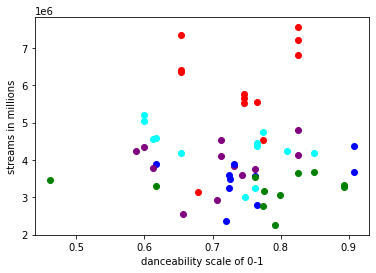

In [77]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['danceability'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph shows how "danceable" a song is using a value provided to us by the Spotify API comapred to the number of streams that song got. Danceability is measured as a value from 0 to 1, where 1 is most danceable. This graph appears to be similar to the graph describing, so they may have been determined using similar characteristisc (i.e. both are measuring how upbeat or fast a song is)

Text(0, 0.5, 'streams in millions')

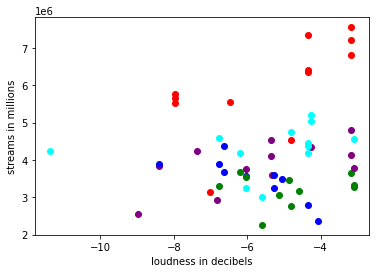

In [78]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['loudness'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('loudness in decibels')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph describes the average volume of each track in our top 5s data set compared to the number of streams each song had. It appears to trend similarly to the last two graphs, indicating that the volume of a track may be correlated with how danceable or energetic a song is.

Text(0, 0.5, 'streams in millions')

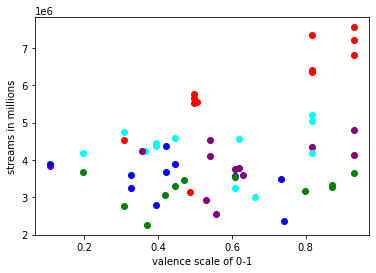

In [79]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['valence'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('valence scale of 0-1')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph describes the "valence" of a song compared to the # of streams it got. Valence is described as the "positivity" of a song where "Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)," according to the Spotify API reference. The reference does not describe how this value is determined, but our data seems to show there may be a correlation between valence and the number of streams a song is getting in the set of number 1 songs. However, this graph does not take into account the other features for the songs. It may be worth trying to consider songs where features except for this one are held to a constant, so that we can consider if there is a correlation between this value and the number of streams.

Text(0, 0.5, 'streams in millions')

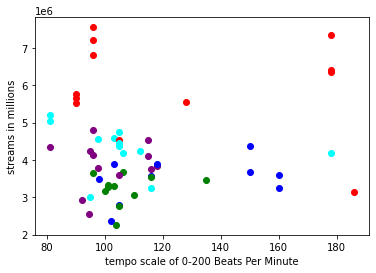

In [80]:
i = 0
for index, row in top5s.iterrows():
    plt.scatter(row['tempo'],row['streams'], color=color_list[i])
    i = (i + 1) % 5

plt.xlabel('tempo scale of 0-200 Beats Per Minute')
plt.ylabel('streams in millions')
#plt.legend(['Number 1 Song For Month', 'Number 2 Song For Month', 'Number 3 Song For Month', 'Number 4 Song For Month', 'Number 5 Song For Month'])

This graph describes the tempo of a song comapred to the number of streams that song has. Given our dataset, it is unclear whether there is a correlation between the tempo of a song and the number of streams it gets.

There appeared to be a potential relationship between valence and the number of streams a song was getting, so it might be interesting to look at what the different features are like for songs with a valence of around .4 or higher

In [81]:
highValenceTopTracks = top5s.loc[top5s['valence'] > .4]
highValenceTopTracks.sort_values('streams', ascending=False).head(10)

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
200,1,1,Shape of You,Ed Sheeran,7549041.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-02-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.581,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
1000,1,1,Despacito - Remix,Luis Fonsi,7332260.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-06-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.228,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
400,1,1,Shape of You,Ed Sheeran,7201132.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-03-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.581,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
600,1,1,Shape of You,Ed Sheeran,6815498.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-04-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.581,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
1200,1,1,Despacito - Remix,Luis Fonsi,6398530.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-07-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.228,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
800,1,1,Despacito - Remix,Luis Fonsi,6360737.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-05-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.228,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
2000,1,1,rockstar,Post Malone,5755610.0,https://open.spotify.com/track/7wGoVu4Dady5GV0...,2017-11-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.247,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk
1800,1,1,rockstar,Post Malone,5649503.0,https://open.spotify.com/track/1OmcAT5Y8eg5bUP...,2017-10-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.247,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk
1600,1,1,Look What You Made Me Do,Taylor Swift,5547962.0,https://open.spotify.com/track/6uFsE1JgZ20EXyU...,2017-09-01,1P17dC1amhFzptugyAO7Il,211853.0,0.204,0.766,0.709,0.000014,0.1260,-6.471,0.1230,0.506,128.070,06HL4z0CvFAxyc27GXpf02
2200,1,1,rockstar,Post Malone,5528701.0,https://open.spotify.com/track/7wGoVu4Dady5GV0...,2017-12-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.247,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk


We have duplicate pieces of data, so lets remove the duplicates for this test. We're going to try to keep the versions of the song that have the most streams

In [82]:
highValenceTopTracks = highValenceTopTracks.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first') # Keeping the last seen version of each song, as that will probably hold it's total streams more accurately
highValenceTopTracks.sort_values('streams', ascending=False).head(10)

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
200,1,1,Shape of You,Ed Sheeran,7549041.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-02-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.581000,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
1000,1,1,Despacito - Remix,Luis Fonsi,7332260.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-06-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.228000,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
2000,1,1,rockstar,Post Malone,5755610.0,https://open.spotify.com/track/7wGoVu4Dady5GV0...,2017-11-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.247000,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk
1600,1,1,Look What You Made Me Do,Taylor Swift,5547962.0,https://open.spotify.com/track/6uFsE1JgZ20EXyU...,2017-09-01,1P17dC1amhFzptugyAO7Il,211853.0,0.204000,0.766,0.709,0.000014,0.1260,-6.471,0.1230,0.506,128.070,06HL4z0CvFAxyc27GXpf02
1001,2,2,I'm the One,DJ Khaled,5208996.0,https://open.spotify.com/track/72Q0FQQo32KJloi...,2017-06-01,1jYiIOC5d6soxkJP81fxq2,288877.0,0.053300,0.599,0.667,0.000000,0.1340,-4.267,0.0367,0.817,80.984,0QHgL1lAIqAw0HtD7YldmP
401,2,2,Something Just Like This,The Chainsmokers,4581789.0,https://open.spotify.com/track/6RUKPb4LETWmmr3...,2017-03-01,6RUKPb4LETWmmr3iAEQktW,247160.0,0.049800,0.617,0.635,0.000014,0.1640,-6.769,0.0317,0.446,103.019,69GGBxA162lTqCwzJG5jLp
1201,2,2,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,4558126.0,https://open.spotify.com/track/1OAh8uOEOvTDqkK...,2017-07-01,45XhKYRRkyeqoW3teSOkCM,204664.0,0.028700,0.613,0.681,0.000000,0.1260,-3.089,0.0778,0.619,97.621,0QHgL1lAIqAw0HtD7YldmP
402,3,3,It Ain't Me (with Selena Gomez),Kygo,4529714.0,https://open.spotify.com/track/3eR23VReFzcdmS7...,2017-03-01,2jRGYG8U5bJzWOH6FLuzvO,192000.0,0.016100,0.713,0.658,0.000138,0.0607,-5.362,0.0748,0.539,115.024,23fqKkggKUBHNkbKtXEls4
803,4,4,HUMBLE.,Kendrick Lamar,4371886.0,https://open.spotify.com/track/7KXjTSCq5nL1LoY...,2017-05-01,7KXjTSCq5nL1LoYtL7XAwS,177000.0,0.000282,0.908,0.621,0.000054,0.0958,-6.638,0.1020,0.421,150.011,2YZyLoL8N0Wb9xBt1NhZWg
2002,3,3,New Rules,Dua Lipa,3758506.0,https://open.spotify.com/track/2ekn2ttSfGqwhha...,2017-11-01,2ekn2ttSfGqwhhate0LSR0,209320.0,0.002610,0.762,0.700,0.000016,0.1530,-6.021,0.0694,0.608,116.073,6M2wZ9GZgrQXHCFfjv46we


In [83]:
highValenceTopTracks = highValenceTopTracks.sort_values('valence', ascending=False)
highValenceTopTracks.head()

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
200,1,1,Shape of You,Ed Sheeran,7549041.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-02-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.5810,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
1604,5,5,"Feels (feat. Pharrell Williams, Katy Perry & B...",Calvin Harris,3324451.0,https://open.spotify.com/track/5bcTCxgc7xVfSaM...,2017-09-01,5bcTCxgc7xVfSaMV3RuVke,223413.0,0.0642,0.893,0.745,0.000000,0.0943,-3.105,0.0571,0.872,101.018,7CajNmpbOovFoOoasH2HaY
1001,2,2,I'm the One,DJ Khaled,5208996.0,https://open.spotify.com/track/72Q0FQQo32KJloi...,2017-06-01,1jYiIOC5d6soxkJP81fxq2,288877.0,0.0533,0.599,0.667,0.000000,0.1340,-4.267,0.0367,0.817,80.984,0QHgL1lAIqAw0HtD7YldmP
1000,1,1,Despacito - Remix,Luis Fonsi,7332260.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-06-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.2280,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
1004,5,5,Attention,Charlie Puth,3169966.0,https://open.spotify.com/track/4iLqG9SeJSnt0cS...,2017-06-01,5cF0dROlMOK5uNZtivgu50,208787.0,0.1090,0.775,0.613,0.000023,0.1340,-4.586,0.0542,0.797,100.066,6VuMaDnrHyPL1p4EHjYLi7


We believe no one feature has a strong effect on the number of streams, but it's possible that a combination of values in different features work together to improve stream count.

Using our list of songs with a high valence, we can look at the relationship between featuers like danceability or tempo and stream count to try to see how songs with both a high valence and varying levels of these features affect streams.

Let's get high valence songs from our original dataframe to have a larger sample size

In [84]:
highValenceTracks = df.loc[(df['valence'] > .5) & (df['valence'] < .8)]
veryHighValenceTracks = df.loc[df['valence'] > .8]
lowValenceTracks = df.loc[(df['valence'] < .5) & (df['valence'] > .3)]
veryLowValenceTracks = df.loc[df['valence'] < .3]
#lowValenceTracks.head()
#highValenceTracks.head()

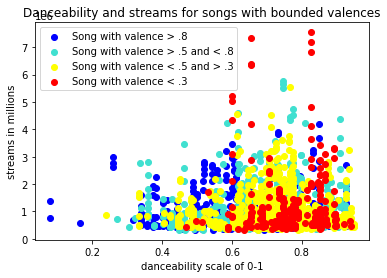

In [85]:
# Plotting songs with a high valence and varying levels of danceability against streams to see if these two values work together to impact stream counts
plt.scatter(veryLowValenceTracks['danceability'],veryLowValenceTracks['streams'], color="blue")
plt.scatter(lowValenceTracks['danceability'],lowValenceTracks['streams'], color="turquoise")
plt.scatter(highValenceTracks['danceability'],highValenceTracks['streams'], color="yellow")
plt.scatter(veryHighValenceTracks['danceability'],veryHighValenceTracks['streams'], color="red")
plt.title('Danceability and streams for songs with bounded valences')
plt.xlabel('danceability scale of 0-1')
plt.ylabel('streams in millions')
plt.legend(['Song with valence > .8', 'Song with valence > .5 and < .8', 'Song with valence < .5 and > .3', 'Song with valence < .3'])

This graph displays how the danceability of a song compares to the number of streams it has for songs that have a high valence (>.5). While there is little indication of a linear correlation, it appears that the songs with the most streams all also have a danceability of > .5. 

No longer seeing the relationship we were seeing earlier between valence and number of streams. Maybe the relationship that leads to more streams is a combination of these features together. It might be worth trying to see if there is a relationship between streams and a combination of features like valence AND loudness or tempo AND danceability

Instead of considering high valence songs, let's looks at the top streamed songs for the 1st day of every month in the year of 2017

In [86]:
top500OverYear = df.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first').head(500)
top500OverYear.head(20)

,index,position,track_name,artist,streams,url,date,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_id
200,1,1,Shape of You,Ed Sheeran,7549041.0,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2017-02-01,7qiZfU4dY1lWllzX7mPBI3,233713.0,0.581000,0.825,0.652,0.000000,0.0931,-3.183,0.0802,0.931,95.977,6eUKZXaKkcviH0Ku9w2n3V
1000,1,1,Despacito - Remix,Luis Fonsi,7332260.0,https://open.spotify.com/track/5CtI0qwDJkDQGwX...,2017-06-01,6rPO02ozF3bM7NnOV4h6s2,228827.0,0.228000,0.653,0.816,0.000000,0.0967,-4.353,0.1670,0.816,178.085,4V8Sr092TqfHkfAA5fXXqG
2000,1,1,rockstar,Post Malone,5755610.0,https://open.spotify.com/track/7wGoVu4Dady5GV0...,2017-11-01,7ytR5pFWmSjzHJIeQkgog4,181733.0,0.247000,0.746,0.690,0.000000,0.1010,-7.956,0.1640,0.497,89.977,4r63FhuTkUYltbVAg5TQnk
1600,1,1,Look What You Made Me Do,Taylor Swift,5547962.0,https://open.spotify.com/track/6uFsE1JgZ20EXyU...,2017-09-01,1P17dC1amhFzptugyAO7Il,211853.0,0.204000,0.766,0.709,0.000014,0.1260,-6.471,0.1230,0.506,128.070,06HL4z0CvFAxyc27GXpf02
1001,2,2,I'm the One,DJ Khaled,5208996.0,https://open.spotify.com/track/72Q0FQQo32KJloi...,2017-06-01,1jYiIOC5d6soxkJP81fxq2,288877.0,0.053300,0.599,0.667,0.000000,0.1340,-4.267,0.0367,0.817,80.984,0QHgL1lAIqAw0HtD7YldmP
1601,2,2,Mi Gente,J Balvin,4756176.0,https://open.spotify.com/track/2rb5MvYT7ZIxbKW...,2017-09-01,4ipnJyDU3Lq15qBAYNqlqK,189440.0,0.017900,0.774,0.687,0.000012,0.1280,-4.818,0.0584,0.308,104.959,1vyhD5VmyZ7KMfW5gqLgo5
401,2,2,Something Just Like This,The Chainsmokers,4581789.0,https://open.spotify.com/track/6RUKPb4LETWmmr3...,2017-03-01,6RUKPb4LETWmmr3iAEQktW,247160.0,0.049800,0.617,0.635,0.000014,0.1640,-6.769,0.0317,0.446,103.019,69GGBxA162lTqCwzJG5jLp
1201,2,2,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,4558126.0,https://open.spotify.com/track/1OAh8uOEOvTDqkK...,2017-07-01,45XhKYRRkyeqoW3teSOkCM,204664.0,0.028700,0.613,0.681,0.000000,0.1260,-3.089,0.0778,0.619,97.621,0QHgL1lAIqAw0HtD7YldmP
402,3,3,It Ain't Me (with Selena Gomez),Kygo,4529714.0,https://open.spotify.com/track/3eR23VReFzcdmS7...,2017-03-01,2jRGYG8U5bJzWOH6FLuzvO,192000.0,0.016100,0.713,0.658,0.000138,0.0607,-5.362,0.0748,0.539,115.024,23fqKkggKUBHNkbKtXEls4
2001,2,2,Havana,Camila Cabello,4438592.0,https://open.spotify.com/track/0ofbQMrRDsUaVKq...,2017-11-01,1rfofaqEpACxVEHIZBJe6W,217307.0,0.184000,0.765,0.523,0.000036,0.1320,-4.333,0.0300,0.394,104.988,4nDoRrQiYLoBzwC5BhVJzF


Text(0.5, 0, 'streams in millions')

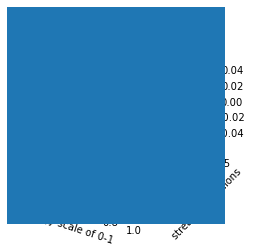

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(top500OverYear['valence'], top500OverYear['tempo'], top500OverYear['streams'])
plt.xlabel('energy scale of 0-1')
plt.ylabel('streams in millions')

<AxesSubplot:>

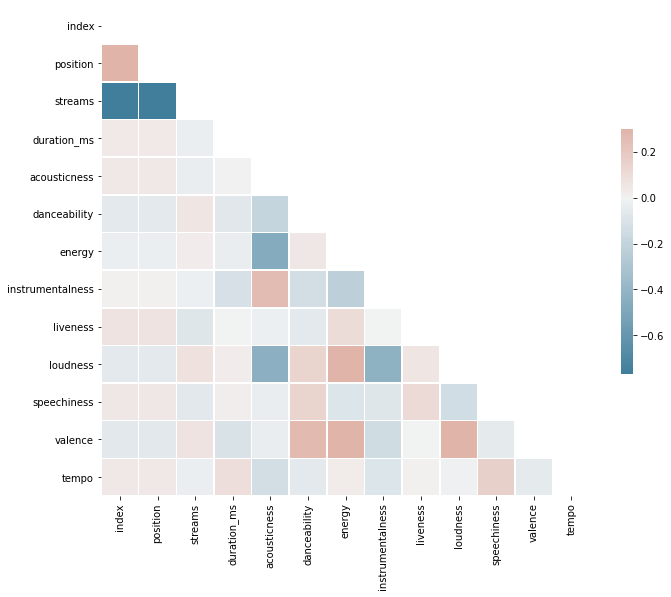

In [88]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It seems like each individual feature has very little effect on the number of streams, which would support our findings above. After seeing this, we had a couple of ideas. It is possible different features we are currently tracking work together to make a song popular, but it is also possible we are missing other important features. After looking back at the most popular songs over the course of our entire dataframe, we noticed the majority of artists were well known or already accomplished. While it is obvious that an artists "followers" or typical listeners will increase the number of streams a song will get, it would be interesting to know if the number of typical listeners was more important than all these other aspects of the song.

We can start by getting the number of followers each artist has for every track entry in our dataframe. The Spotify API also provides a "popularity" index from 0 to 100, with 100 being the most popular. We will get this information, as well. There will be repetition between duplicate entries for an artist, but we are keeping these in so that we can still build a dataframe.

In [ ]:
popularity_index_list = []
num_followers_list = []
for index, row in df.iterrows():
    print(row)
    if (type(row['artist_id']) == str):
        artist_object = sp.artist(row['artist_id'])
        followers_object = artist_object['followers']
        popularity_value = artist_object['popularity']
        followers_value = followers_object['total']
        popularity_index_list.append(popularity_value)
        num_followers_list.append(followers_value)
    else:
        popularity_index_list.append(np.nan)
        num_followers_list.append(np.nan)

index                                                               1
position                                                            1
track_name                                                    Starboy
artist                                                     The Weeknd
streams                                                   3.13562e+06
url                 https://open.spotify.com/track/5aAx2yezTd8zXrk...
date                                                       2017-01-01
track_id                                       7MXVkk9YMctZqd1Srtv4MB
duration_ms                                                    230453
acousticness                                                    0.141
danceability                                                    0.679
energy                                                          0.587
instrumentalness                                             6.35e-06
liveness                                                        0.137
loudness            

Name: 9, dtype: object
index                                                              11
position                                                           11
track_name                                    Chantaje (feat. Maluma)
artist                                                        Shakira
streams                                                   1.89321e+06
url                 https://open.spotify.com/track/6mICuAdrwEjh6Y6...
date                                                       2017-01-01
track_id                                       6mICuAdrwEjh6Y6lroV2Kg
duration_ms                                                    195840
acousticness                                                    0.187
danceability                                                    0.852
energy                                                          0.773
instrumentalness                                             3.05e-05
liveness                                                        0.1

index                                                              20
position                                                           20
track_name                             Don't Let Me Down (feat. Daya)
artist                                               The Chainsmokers
streams                                                   1.43847e+06
url                 https://open.spotify.com/track/0QsvXIfqM0zZoer...
date                                                       2017-01-01
track_id                                       15BlympuVSfZFROojEMY2M
duration_ms                                                    218933
acousticness                                                   0.0751
danceability                                                    0.428
energy                                                          0.656
instrumentalness                                                0.181
liveness                                                         0.15
loudness            

index                                                              28
position                                                           28
track_name                                                All We Know
artist                                               The Chainsmokers
streams                                                   1.23814e+06
url                 https://open.spotify.com/track/2rizacJSyD9S1IQ...
date                                                       2017-01-01
track_id                                       2rizacJSyD9S1IQUxUxnsK
duration_ms                                                    194080
acousticness                                                    0.097
danceability                                                    0.662
energy                                                          0.586
instrumentalness                                              0.00272
liveness                                                        0.115
loudness            

index                                                              37
position                                                           37
track_name                                Vente Pa' Ca (feat. Maluma)
artist                                                   Ricky Martin
streams                                                    1.0169e+06
url                 https://open.spotify.com/track/7DM4BPaS7uofFul...
date                                                       2017-01-01
track_id                                       7DM4BPaS7uofFul3ywMe46
duration_ms                                                    259196
acousticness                                                  0.00431
danceability                                                    0.663
energy                                                           0.92
instrumentalness                                             1.69e-05
liveness                                                        0.101
loudness            

index                                                              47
position                                                           47
track_name                                  Otra vez (feat. J Balvin)
artist                                                  Zion & Lennox
streams                                                        893174
url                 https://open.spotify.com/track/3QwBODjSEzelZyV...
date                                                       2017-01-01
track_id                                       3QwBODjSEzelZyVjxPOHdq
duration_ms                                                    209453
acousticness                                                   0.0559
danceability                                                    0.832
energy                                                          0.772
instrumentalness                                             0.000486
liveness                                                         0.44
loudness            

Name: 55, dtype: object
index                                                              57
position                                                           57
track_name                                               La Bicicleta
artist                                                   Carlos Vives
streams                                                        810362
url                 https://open.spotify.com/track/0sXvAOmXgjR2QUq...
date                                                       2017-01-01
track_id                                       0Gx4VrHzS7pZOEAGrmXXBH
duration_ms                                                    229510
acousticness                                                     0.21
danceability                                                    0.745
energy                                                          0.944
instrumentalness                                             1.45e-06
liveness                                                        0.

index                                                              65
position                                                           65
track_name                                                    Deja Vu
artist                                                        J. Cole
streams                                                        748367
url                 https://open.spotify.com/track/6I6NX6tjGsxFAsI...
date                                                       2017-01-01
track_id                                       6I6NX6tjGsxFAsIfGzY9lJ
duration_ms                                                    264747
acousticness                                                    0.352
danceability                                                    0.657
energy                                                          0.421
instrumentalness                                             0.000218
liveness                                                        0.187
loudness            

index                                                              74
position                                                           74
track_name                              Juju on That Beat (TZ Anthem)
artist                                                 Zay Hilfigerrr
streams                                                        672103
url                 https://open.spotify.com/track/1lItf5ZXJc1by9S...
date                                                       2017-01-01
track_id                                       1lItf5ZXJc1by9SbPeljFd
duration_ms                                                    144244
acousticness                                                  0.00381
danceability                                                    0.807
energy                                                          0.887
instrumentalness                                                    0
liveness                                                        0.391
loudness            

index                                                              84
position                                                           84
track_name                                                      Human
artist                                                 Rag'n'Bone Man
streams                                                        615851
url                 https://open.spotify.com/track/58zsLZPvfflaiIb...
date                                                       2017-01-01
track_id                                       58zsLZPvfflaiIbNWoA22O
duration_ms                                                    200187
acousticness                                                    0.393
danceability                                                    0.602
energy                                                          0.707
instrumentalness                                                    0
liveness                                                        0.165
loudness            

index                                                              92
position                                                           92
track_name                                              Make Me (Cry)
artist                                                     Noah Cyrus
streams                                                        577810
url                 https://open.spotify.com/track/2BrzlUj1u1CtvaJ...
date                                                       2017-01-01
track_id                                       2BrzlUj1u1CtvaJDGIKpsP
duration_ms                                                    242081
acousticness                                                    0.592
danceability                                                    0.588
energy                                                          0.471
instrumentalness                                              0.00146
liveness                                                       0.0733
loudness            

index                                                             100
position                                                          100
track_name                                     Dile Que Tu Me Quieres
artist                                                          Ozuna
streams                                                        549784
url                 https://open.spotify.com/track/20ZAJdsKB5IGbGj...
date                                                       2017-01-01
track_id                                       5u5MvmVtitax9R1Mxh3reC
duration_ms                                                    226520
acousticness                                                   0.0864
danceability                                                    0.773
energy                                                          0.757
instrumentalness                                             3.73e-06
liveness                                                       0.0727
loudness            

index                                                             111
position                                                          111
track_name                                                 Final Song
artist                                                             MØ
streams                                                        505038
url                 https://open.spotify.com/track/4qqArAiTPueDxIp...
date                                                       2017-01-01
track_id                                       4qqArAiTPueDxIp7cf87h7
duration_ms                                                    235827
acousticness                                                    0.014
danceability                                                    0.695
energy                                                          0.672
instrumentalness                                             8.44e-05
liveness                                                       0.0756
loudness            

Name: 119, dtype: object
index                                                             121
position                                                          121
track_name                                        Roses (feat. ROZES)
artist                                               The Chainsmokers
streams                                                        475190
url                 https://open.spotify.com/track/6O6M7pJLABmfBRo...
date                                                       2017-01-01
track_id                                       3FWPoYBDserKdzcattMFGa
duration_ms                                                    225813
acousticness                                                   0.0299
danceability                                                    0.718
energy                                                          0.808
instrumentalness                                              0.00414
liveness                                                        0

Name: 128, dtype: object
index                                                             130
position                                                          130
track_name                                                   No Money
artist                                                       Galantis
streams                                                        453779
url                 https://open.spotify.com/track/0gb1J5UrTpzaU1s...
date                                                       2017-01-01
track_id                                       0gb1J5UrTpzaU1s3nupgCd
duration_ms                                                    189127
acousticness                                                   0.0282
danceability                                                    0.671
energy                                                          0.916
instrumentalness                                              0.00762
liveness                                                         

Name: 137, dtype: object
index                                                             139
position                                                          139
track_name                           Me llamas (feat. Maluma) - Remix
artist                                                        Piso 21
streams                                                        439910
url                 https://open.spotify.com/track/5hEM0JchdVzQ5Pw...
date                                                       2017-01-01
track_id                                       5hEM0JchdVzQ5PwvSfITeX
duration_ms                                                    210323
acousticness                                                    0.547
danceability                                                     0.76
energy                                                          0.838
instrumentalness                                              1.3e-06
liveness                                                       0.

Name: 146, dtype: object
index                                                             148
position                                                          148
track_name                             Dynamite (feat. Pretty Sister)
artist                                                          Nause
streams                                                        413497
url                 https://open.spotify.com/track/2Ae5awwKvQpTBKQ...
date                                                       2017-01-01
track_id                                       2Ae5awwKvQpTBKQHr1TYCg
duration_ms                                                    195429
acousticness                                                   0.0548
danceability                                                    0.811
energy                                                          0.801
instrumentalness                                             2.09e-05
liveness                                                       0.

index                                                             157
position                                                          157
track_name                                          Love On The Brain
artist                                                        Rihanna
streams                                                        397058
url                 https://open.spotify.com/track/2aksifNn5ph8igD...
date                                                       2017-01-01
track_id                                       5oO3drDxtziYU2H1X23ZIp
duration_ms                                                    224000
acousticness                                                   0.0717
danceability                                                    0.509
energy                                                          0.637
instrumentalness                                             1.08e-05
liveness                                                       0.0789
loudness            

index                                                             167
position                                                          167
track_name                             Uptown Funk (feat. Bruno Mars)
artist                                                    Mark Ronson
streams                                                        385214
url                 https://open.spotify.com/track/32OlwWuMpZ6b0aN...
date                                                       2017-01-01
track_id                                       32OlwWuMpZ6b0aN2RZOeMS
duration_ms                                                    269667
acousticness                                                  0.00801
danceability                                                    0.856
energy                                                          0.609
instrumentalness                                             8.15e-05
liveness                                                       0.0344
loudness            

Name: 175, dtype: object
index                                                             177
position                                                          177
track_name                                            Please Don't Go
artist                                                     Joel Adams
streams                                                        357531
url                 https://open.spotify.com/track/3cNjgVBKTJ1SvKh...
date                                                       2017-01-01
track_id                                       3cNjgVBKTJ1SvKhunrCdVy
duration_ms                                                    210580
acousticness                                                   0.0118
danceability                                                    0.513
energy                                                          0.768
instrumentalness                                             1.94e-05
liveness                                                        0

index                                                             186
position                                                          186
track_name                                 Used to This (feat. Drake)
artist                                                         Future
streams                                                        344032
url                 https://open.spotify.com/track/78sr3ogs4UzITcC...
date                                                       2017-01-01
track_id                                       3V8sM5OOG6YfDuDLa2IIYJ
duration_ms                                                    180520
acousticness                                                   0.0312
danceability                                                    0.618
energy                                                          0.727
instrumentalness                                                    0
liveness                                                        0.196
loudness            

Name: 193, dtype: object
index                                                             195
position                                                          195
track_name                           Taped up Heart (feat. Clara Mae)
artist                                                          KREAM
streams                                                        333469
url                 https://open.spotify.com/track/26hcyzSE154xMZC...
date                                                       2017-01-01
track_id                                       26hcyzSE154xMZCbFdtInA
duration_ms                                                    218507
acousticness                                                    0.152
danceability                                                    0.675
energy                                                          0.937
instrumentalness                                                    0
liveness                                                        0

index                                                               3
position                                                            3
track_name          I Don’t Wanna Live Forever (Fifty Shades Darke...
artist                                                           ZAYN
streams                                                   3.83828e+06
url                 https://open.spotify.com/track/3NdDpSvN911VPGi...
date                                                       2017-02-01
track_id                                       4s1gw3EgOpc9InInSqiMiv
duration_ms                                                    245653
acousticness                                                   0.0586
danceability                                                    0.732
energy                                                          0.445
instrumentalness                                             1.65e-05
liveness                                                        0.215
loudness            

index                                                              12
position                                                           12
track_name                                           Don't Wanna Know
artist                                                       Maroon 5
streams                                                   2.43769e+06
url                 https://open.spotify.com/track/5MFzQMkrl1FOOng...
date                                                       2017-02-01
track_id                                       1nueTG77MzNkJTKQ0ZdGzT
duration_ms                                                    214265
acousticness                                                    0.343
danceability                                                    0.783
energy                                                           0.61
instrumentalness                                                    0
liveness                                                       0.0983
loudness            

index                                                              22
position                                                           22
track_name                                                  All Night
artist                                                      The Vamps
streams                                                   1.76552e+06
url                 https://open.spotify.com/track/1yNyoWWWikbLhwI...
date                                                       2017-02-01
track_id                                       0dXNQ8dckG4eYfEtq9zcva
duration_ms                                                    197640
acousticness                                                   0.0041
danceability                                                    0.538
energy                                                          0.804
instrumentalness                                                    0
liveness                                                         0.33
loudness            

index                                                              33
position                                                           33
track_name                                 Reggaetón Lento (Bailemos)
artist                                                           CNCO
streams                                                   1.46336e+06
url                 https://open.spotify.com/track/3AEZUABDXNtecAO...
date                                                       2017-02-01
track_id                                       3AEZUABDXNtecAOSC1qTfo
duration_ms                                                    222560
acousticness                                                      0.4
danceability                                                    0.761
energy                                                          0.838
instrumentalness                                                    0
liveness                                                        0.176
loudness            

index                                                              42
position                                                           42
track_name                                               I Would Like
artist                                                   Zara Larsson
streams                                                   1.33069e+06
url                 https://open.spotify.com/track/4Q4jmPHwu0wrJvq...
date                                                       2017-02-01
track_id                                       4Q4jmPHwu0wrJvqrld0FQ6
duration_ms                                                    226720
acousticness                                                   0.0853
danceability                                                    0.486
energy                                                          0.713
instrumentalness                                                    0
liveness                                                       0.0839
loudness            

index                                                              51
position                                                           51
track_name                                               By Your Side
artist                                                     Jonas Blue
streams                                                   1.12458e+06
url                 https://open.spotify.com/track/1D3ODoXHBLpdxol...
date                                                       2017-02-01
track_id                                       7H3ojI1BsVy0dEJENqMt1k
duration_ms                                                    274933
acousticness                                                   0.0849
danceability                                                    0.653
energy                                                          0.429
instrumentalness                                              0.00371
liveness                                                       0.0693
loudness            

index                                                              60
position                                                           60
track_name                             Don't Let Me Down (feat. Daya)
artist                                               The Chainsmokers
streams                                                        936031
url                 https://open.spotify.com/track/0QsvXIfqM0zZoer...
date                                                       2017-02-01
track_id                                       15BlympuVSfZFROojEMY2M
duration_ms                                                    218933
acousticness                                                   0.0751
danceability                                                    0.428
energy                                                          0.656
instrumentalness                                                0.181
liveness                                                         0.15
loudness            

index                                                              68
position                                                           68
track_name                                                      Touch
artist                                                     Little Mix
streams                                                        826240
url                 https://open.spotify.com/track/5Ua3GXyHwiSfpNT...
date                                                       2017-02-01
track_id                                       6qWEpnyU43Bcrx3vfbGuVm
duration_ms                                                    206180
acousticness                                                  0.00655
danceability                                                    0.603
energy                                                          0.964
instrumentalness                                             3.04e-06
liveness                                                        0.143
loudness            

index                                                              77
position                                                           77
track_name                                          Thinking out Loud
artist                                                     Ed Sheeran
streams                                                        762905
url                 https://open.spotify.com/track/1Slwb6dOYkBlWal...
date                                                       2017-02-01
track_id                                       34gCuhDGsG4bRPIf9bb02f
duration_ms                                                    281560
acousticness                                                    0.474
danceability                                                    0.781
energy                                                          0.445
instrumentalness                                                    0
liveness                                                        0.184
loudness            

Name: 285, dtype: object
index                                                              87
position                                                           87
track_name                                                   The Mack
artist                                                         Nevada
streams                                                        709193
url                 https://open.spotify.com/track/7aV2mflaASUmGhC...
date                                                       2017-02-01
track_id                                       2fUZ3aMp8amSaV0mp8s6rQ
duration_ms                                                    167038
acousticness                                                   0.0626
danceability                                                    0.711
energy                                                          0.882
instrumentalness                                                    0
liveness                                                        0

index                                                              95
position                                                           95
track_name                                     Dile Que Tu Me Quieres
artist                                                          Ozuna
streams                                                        677902
url                 https://open.spotify.com/track/20ZAJdsKB5IGbGj...
date                                                       2017-02-01
track_id                                       5u5MvmVtitax9R1Mxh3reC
duration_ms                                                    226520
acousticness                                                   0.0864
danceability                                                    0.773
energy                                                          0.757
instrumentalness                                             3.73e-06
liveness                                                       0.0727
loudness            

index                                                             105
position                                                          105
track_name                                   Cake - Challenge Version
artist                                                       Flo Rida
streams                                                        647871
url                 https://open.spotify.com/track/6t2ubAB4iSYOuIp...
date                                                       2017-02-01
track_id                                       6t2ubAB4iSYOuIpRAOGd4t
duration_ms                                                    157165
acousticness                                                   0.0729
danceability                                                    0.786
energy                                                          0.854
instrumentalness                                             1.63e-06
liveness                                                        0.179
loudness            

index                                                             113
position                                                          113
track_name             Trust Nobody (feat. Selena Gomez & Tory Lanez)
artist                                                   Cashmere Cat
streams                                                        624266
url                 https://open.spotify.com/track/2wDjpPW3HZdA9qu...
date                                                       2017-02-01
track_id                                       5qYp1Wf3gh0lGWdIS5lIrX
duration_ms                                                    215670
acousticness                                                    0.497
danceability                                                     0.49
energy                                                          0.625
instrumentalness                                                    0
liveness                                                        0.118
loudness            

index                                                             121
position                                                          121
track_name                                                Oceans Away
artist                                                  A R I Z O N A
streams                                                        594664
url                 https://open.spotify.com/track/6A8dnC0xkiuWN4B...
date                                                       2017-02-01
track_id                                       6A8dnC0xkiuWN4BshmTB2I
duration_ms                                                    194013
acousticness                                                     0.13
danceability                                                    0.617
energy                                                          0.642
instrumentalness                                                0.157
liveness                                                       0.0929
loudness            

index                                                             130
position                                                          130
track_name                                               Call Casting
artist                                                          Migos
streams                                                        565902
url                 https://open.spotify.com/track/0jOfl1nZf6sVBTG...
date                                                       2017-02-01
track_id                                       0jOfl1nZf6sVBTG08Q4brn
duration_ms                                                    232705
acousticness                                                   0.0962
danceability                                                    0.852
energy                                                          0.727
instrumentalness                                                    0
liveness                                                        0.154
loudness            

Name: 337, dtype: object
index                                                             139
position                                                          139
track_name                                                   Into You
artist                                                  Ariana Grande
streams                                                        536022
url                 https://open.spotify.com/track/7yHEDfrJNd0zWOf...
date                                                       2017-02-01
track_id                                       2meEiZKWkiN28gITzFwQo5
duration_ms                                                    244453
acousticness                                                   0.0162
danceability                                                    0.623
energy                                                          0.734
instrumentalness                                             1.75e-06
liveness                                                        0

index                                                             148
position                                                          148
track_name                                         Andas En Mi Cabeza
artist                                                  Chino & Nacho
streams                                                        515991
url                 https://open.spotify.com/track/5mey7CLLuFToM2P...
date                                                       2017-02-01
track_id                                       23WI5V2eD4EyGKxSl7Pyeq
duration_ms                                                    247493
acousticness                                                   0.0244
danceability                                                    0.671
energy                                                          0.954
instrumentalness                                                    0
liveness                                                        0.111
loudness            

index                                                             157
position                                                          157
track_name                                          Dancing On My Own
artist                                                    Calum Scott
streams                                                        478820
url                 https://open.spotify.com/track/02WacdrRpm4zlP8...
date                                                       2017-02-01
track_id                                       2BOqDYLOJBiMOXShCV1neZ
duration_ms                                                    260285
acousticness                                                    0.839
danceability                                                    0.682
energy                                                          0.173
instrumentalness                                             3.26e-05
liveness                                                       0.0983
loudness            

Name: 365, dtype: object
index                                                             167
position                                                          167
track_name                                             Me, Myself & I
artist                                                         G-Eazy
streams                                                        459424
url                 https://open.spotify.com/track/40YcuQysJ0KlGQT...
date                                                       2017-02-01
track_id                                       40YcuQysJ0KlGQTeGUosTC
duration_ms                                                    251467
acousticness                                                   0.0184
danceability                                                    0.756
energy                                                          0.674
instrumentalness                                                    0
liveness                                                        0

index                                                             175
position                                                          175
track_name                                              You Was Right
artist                                                   Lil Uzi Vert
streams                                                        438579
url                 https://open.spotify.com/track/2ANLarE8yHVsLWW...
date                                                       2017-02-01
track_id                                       2ANLarE8yHVsLWW21nj79M
duration_ms                                                    163944
acousticness                                                    0.069
danceability                                                    0.843
energy                                                          0.359
instrumentalness                                                    0
liveness                                                         0.12
loudness            

Name: 382, dtype: object
index                                                             184
position                                                          184
track_name                                                        Sex
artist                                                    Cheat Codes
streams                                                        422008
url                 https://open.spotify.com/track/5DA77EqppDmCTWG...
date                                                       2017-02-01
track_id                                       5JtvedSVWW9McnoEAPJwQm
duration_ms                                                    162453
acousticness                                                    0.281
danceability                                                    0.857
energy                                                          0.427
instrumentalness                                                    0
liveness                                                        0

Name: 391, dtype: object
index                                                             193
position                                                          193
track_name                                          Never Be Like You
artist                                                          Flume
streams                                                        407829
url                 https://open.spotify.com/track/12REd1n8PeiHHWO...
date                                                       2017-02-01
track_id                                       5WI2ltQIdwgzf1SNE76JyR
duration_ms                                                    234910
acousticness                                                    0.453
danceability                                                    0.444
energy                                                          0.557
instrumentalness                                                    0
liveness                                                        0

index                                                               2
position                                                            2
track_name                                   Something Just Like This
artist                                               The Chainsmokers
streams                                                   4.58179e+06
url                 https://open.spotify.com/track/6RUKPb4LETWmmr3...
date                                                       2017-03-01
track_id                                       6RUKPb4LETWmmr3iAEQktW
duration_ms                                                    247160
acousticness                                                   0.0498
danceability                                                    0.617
energy                                                          0.635
instrumentalness                                             1.44e-05
liveness                                                        0.164
loudness            

index                                                              12
position                                                           12
track_name                                           I Feel It Coming
artist                                                     The Weeknd
streams                                                   2.41032e+06
url                 https://open.spotify.com/track/5GXAXm5YOmYT0kL...
date                                                       2017-03-01
track_id                                       3dhjNA0jGA8vHBQ1VdD6vV
duration_ms                                                    269187
acousticness                                                    0.428
danceability                                                    0.773
energy                                                          0.819
instrumentalness                                                    0
liveness                                                       0.0679
loudness            

index                                                              19
position                                                           19
track_name                    Call On Me - Ryan Riback Extended Remix
artist                                                        Starley
streams                                                   2.18928e+06
url                 https://open.spotify.com/track/78rIJddV4X0HkNA...
date                                                       2017-03-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                          NaN
loudness            

Name: 424, dtype: object
index                                                              26
position                                                           26
track_name                                    Chantaje (feat. Maluma)
artist                                                        Shakira
streams                                                    1.7785e+06
url                 https://open.spotify.com/track/6mICuAdrwEjh6Y6...
date                                                       2017-03-01
track_id                                       6mICuAdrwEjh6Y6lroV2Kg
duration_ms                                                    195840
acousticness                                                    0.187
danceability                                                    0.852
energy                                                          0.773
instrumentalness                                             3.05e-05
liveness                                                        0

Name: 433, dtype: object
index                                                              35
position                                                           35
track_name                                                  Fake Love
artist                                                          Drake
streams                                                   1.50854e+06
url                 https://open.spotify.com/track/343YBumqHu19cGo...
date                                                       2017-03-01
track_id                                       343YBumqHu19cGoGARUTsd
duration_ms                                                    210937
acousticness                                                    0.105
danceability                                                    0.928
energy                                                          0.481
instrumentalness                                                    0
liveness                                                        0

index                                                              43
position                                                           43
track_name                                 Reggaetón Lento (Bailemos)
artist                                                           CNCO
streams                                                   1.32357e+06
url                 https://open.spotify.com/track/3AEZUABDXNtecAO...
date                                                       2017-03-01
track_id                                       3AEZUABDXNtecAOSC1qTfo
duration_ms                                                    222560
acousticness                                                      0.4
danceability                                                    0.761
energy                                                          0.838
instrumentalness                                                    0
liveness                                                        0.176
loudness            

Name: 451, dtype: object
index                                                              53
position                                                           53
track_name                                               Sunset Lover
artist                                                  Petit Biscuit
streams                                                   1.00685e+06
url                 https://open.spotify.com/track/0hNduWmlWmEmuwE...
date                                                       2017-03-01
track_id                                       0hNduWmlWmEmuwEFcYvRu1
duration_ms                                                    237793
acousticness                                                    0.729
danceability                                                    0.783
energy                                                          0.467
instrumentalness                                                0.809
liveness                                                        0

Name: 460, dtype: object
index                                                              62
position                                                           62
track_name                                          Love On The Brain
artist                                                        Rihanna
streams                                                        909941
url                 https://open.spotify.com/track/2aksifNn5ph8igD...
date                                                       2017-03-01
track_id                                       5oO3drDxtziYU2H1X23ZIp
duration_ms                                                    224000
acousticness                                                   0.0717
danceability                                                    0.509
energy                                                          0.637
instrumentalness                                             1.08e-05
liveness                                                       0.

index                                                              70
position                                                           70
track_name                        Comin Out Strong (feat. The Weeknd)
artist                                                         Future
streams                                                        855670
url                 https://open.spotify.com/track/3mRcWCyteY2133a...
date                                                       2017-03-01
track_id                                       1B87ZDrD3Pno9hS4stamWO
duration_ms                                                    254370
acousticness                                                     0.29
danceability                                                    0.628
energy                                                          0.481
instrumentalness                                                    0
liveness                                                        0.118
loudness            

Name: 478, dtype: object
index                                                              80
position                                                           80
track_name                                                   Heathens
artist                                              Twenty One Pilots
streams                                                        794733
url                 https://open.spotify.com/track/6i0V12jOa3mr6uu...
date                                                       2017-03-01
track_id                                       6i0V12jOa3mr6uu4WYhUBr
duration_ms                                                    195920
acousticness                                                   0.0841
danceability                                                    0.732
energy                                                          0.396
instrumentalness                                             3.58e-05
liveness                                                        0

index                                                              88
position                                                           88
track_name                           Me llamas (feat. Maluma) - Remix
artist                                                        Piso 21
streams                                                        747167
url                 https://open.spotify.com/track/5hEM0JchdVzQ5Pw...
date                                                       2017-03-01
track_id                                       5hEM0JchdVzQ5PwvSfITeX
duration_ms                                                    210323
acousticness                                                    0.547
danceability                                                     0.76
energy                                                          0.838
instrumentalness                                              1.3e-06
liveness                                                       0.0664
loudness            

index                                                              99
position                                                           99
track_name                                              Make Me (Cry)
artist                                                     Noah Cyrus
streams                                                        687277
url                 https://open.spotify.com/track/2BrzlUj1u1CtvaJ...
date                                                       2017-03-01
track_id                                       2BrzlUj1u1CtvaJDGIKpsP
duration_ms                                                    242081
acousticness                                                    0.592
danceability                                                    0.588
energy                                                          0.471
instrumentalness                                              0.00146
liveness                                                       0.0733
loudness            

Name: 507, dtype: object
index                                                             109
position                                                          109
track_name                                                 goosebumps
artist                                                   Travis Scott
streams                                                        654545
url                 https://open.spotify.com/track/6gBFPUFcJLzWGx4...
date                                                       2017-03-01
track_id                                       6gBFPUFcJLzWGx4lenP6h2
duration_ms                                                    243837
acousticness                                                   0.0847
danceability                                                    0.841
energy                                                          0.728
instrumentalness                                                    0
liveness                                                        0

index                                                             116
position                                                          116
track_name                    No Problem (feat. Lil Wayne & 2 Chainz)
artist                                              Chance the Rapper
streams                                                        615562
url                 https://open.spotify.com/track/0v9Wz8o0BT8DU38...
date                                                       2017-03-01
track_id                                       0v9Wz8o0BT8DU38R4ddjeH
duration_ms                                                    304607
acousticness                                                    0.156
danceability                                                    0.652
energy                                                          0.795
instrumentalness                                                    0
liveness                                                        0.123
loudness            

index                                                             123
position                                                          123
track_name                                             Shooting Stars
artist                                                    Bag Raiders
streams                                                        591465
url                 https://open.spotify.com/track/0UeYCHOETPfai02...
date                                                       2017-03-01
track_id                                       0UeYCHOETPfai02uskjJ3x
duration_ms                                                    235813
acousticness                                                   0.0893
danceability                                                    0.636
energy                                                           0.72
instrumentalness                                               0.0178
liveness                                                       0.0868
loudness            

index                                                             131
position                                                          131
track_name                            Gyal You A Party Animal - Remix
artist                                                   Charly Black
streams                                                        575303
url                 https://open.spotify.com/track/1AkTW13ysu0AJrw...
date                                                       2017-03-01
track_id                                       0Rj2yNpEvXOl8yn9UOuIRs
duration_ms                                                    224320
acousticness                                                   0.0612
danceability                                                    0.729
energy                                                          0.894
instrumentalness                                                    0
liveness                                                         0.36
loudness            

Name: 539, dtype: object
index                                                             141
position                                                          141
track_name                                                   Reminder
artist                                                     The Weeknd
streams                                                        551297
url                 https://open.spotify.com/track/37F0uwRSrdzkBiu...
date                                                       2017-03-01
track_id                                       37F0uwRSrdzkBiuj0D5UHI
duration_ms                                                    218880
acousticness                                                    0.142
danceability                                                    0.706
energy                                                          0.505
instrumentalness                                                    0
liveness                                                        0

index                                                             150
position                                                          150
track_name                                                  No Favors
artist                                                       Big Sean
streams                                                        520933
url                 https://open.spotify.com/track/1MksGqIztTT6M9R...
date                                                       2017-03-01
track_id                                       1MksGqIztTT6M9R1ErKVs8
duration_ms                                                    325840
acousticness                                                    0.629
danceability                                                    0.482
energy                                                          0.781
instrumentalness                                             2.87e-06
liveness                                                        0.413
loudness            

Name: 558, dtype: object
index                                                             160
position                                                          160
track_name                                                 I Love You
artist                                             Axwell /\ Ingrosso
streams                                                        486378
url                 https://open.spotify.com/track/11Fo4dAH31K7UZH...
date                                                       2017-03-01
track_id                                       6CcJMwBtXByIz4zQLzFkKc
duration_ms                                                    291796
acousticness                                                    0.952
danceability                                                    0.421
energy                                                          0.131
instrumentalness                                              0.00453
liveness                                                        0

Name: 566, dtype: object
index                                                             168
position                                                          168
track_name                                         Shout Out to My Ex
artist                                                     Little Mix
streams                                                        474363
url                 https://open.spotify.com/track/0YHUITU3w6ws1v8...
date                                                       2017-03-01
track_id                                       0ErK6K0kYr0Ow2RkPMhmMs
duration_ms                                                    246240
acousticness                                                   0.0242
danceability                                                    0.773
energy                                                          0.747
instrumentalness                                             8.99e-06
liveness                                                        0

Name: 574, dtype: object
index                                                             176
position                                                          176
track_name                                              White Iverson
artist                                                    Post Malone
streams                                                        456369
url                 https://open.spotify.com/track/6eT7xZZlB2mwyzJ...
date                                                       2017-03-01
track_id                                       6eT7xZZlB2mwyzJ2sUKG6w
duration_ms                                                    256533
acousticness                                                    0.233
danceability                                                    0.675
energy                                                          0.562
instrumentalness                                                    0
liveness                                                       0.

index                                                             184
position                                                          184
track_name                                                   The Mack
artist                                                         Nevada
streams                                                        443869
url                 https://open.spotify.com/track/7aV2mflaASUmGhC...
date                                                       2017-03-01
track_id                                       2fUZ3aMp8amSaV0mp8s6rQ
duration_ms                                                    167038
acousticness                                                   0.0626
danceability                                                    0.711
energy                                                          0.882
instrumentalness                                                    0
liveness                                                        0.226
loudness            

index                                                             194
position                                                          194
track_name          Another Day Of Sun - From "La La Land" Soundtrack
artist                                                La La Land Cast
streams                                                        431559
url                 https://open.spotify.com/track/0zCfmceT1YvtZXG...
date                                                       2017-03-01
track_id                                       4sZPXhxVfORQGP3XFPNCST
duration_ms                                                    228173
acousticness                                                   0.0161
danceability                                                    0.588
energy                                                          0.742
instrumentalness                                             3.97e-06
liveness                                                        0.653
loudness            

Name: 602, dtype: object
index                                                               4
position                                                            4
track_name                                   Something Just Like This
artist                                               The Chainsmokers
streams                                                   3.89032e+06
url                 https://open.spotify.com/track/6RUKPb4LETWmmr3...
date                                                       2017-04-01
track_id                                       6RUKPb4LETWmmr3iAEQktW
duration_ms                                                    247160
acousticness                                                   0.0498
danceability                                                    0.617
energy                                                          0.635
instrumentalness                                             1.44e-05
liveness                                                        0

Name: 613, dtype: object
index                                                              15
position                                                           15
track_name          I Don’t Wanna Live Forever (Fifty Shades Darke...
artist                                                           ZAYN
streams                                                   2.57738e+06
url                 https://open.spotify.com/track/3NdDpSvN911VPGi...
date                                                       2017-04-01
track_id                                       4s1gw3EgOpc9InInSqiMiv
duration_ms                                                    245653
acousticness                                                   0.0586
danceability                                                    0.732
energy                                                          0.445
instrumentalness                                             1.65e-05
liveness                                                        0

Name: 621, dtype: object
index                                                              23
position                                                           23
track_name                 Swalla (feat. Nicki Minaj & Ty Dolla $ign)
artist                                                   Jason Derulo
streams                                                   2.05399e+06
url                 https://open.spotify.com/track/6kex4EBAj0WHXDK...
date                                                       2017-04-01
track_id                                       6kex4EBAj0WHXDKZMEJaaF
duration_ms                                                    216409
acousticness                                                    0.075
danceability                                                    0.696
energy                                                          0.817
instrumentalness                                                    0
liveness                                                        0

Name: 630, dtype: object
index                                                              32
position                                                           32
track_name                                                    Perfect
artist                                                     Ed Sheeran
streams                                                   1.66169e+06
url                 https://open.spotify.com/track/0tgVpDi06FyKpA1...
date                                                       2017-04-01
track_id                                       0tgVpDi06FyKpA1z0VMD4v
duration_ms                                                    263400
acousticness                                                    0.163
danceability                                                    0.599
energy                                                          0.448
instrumentalness                                                    0
liveness                                                        0

Name: 638, dtype: object
index                                                              40
position                                                           40
track_name                 Run Up (feat. PARTYNEXTDOOR & Nicki Minaj)
artist                                                    Major Lazer
streams                                                   1.56466e+06
url                 https://open.spotify.com/track/0fg8CqpjdojMyXL...
date                                                       2017-04-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                         

index                                                              49
position                                                           49
track_name                       Still Got Time (feat. PARTYNEXTDOOR)
artist                                                           ZAYN
streams                                                   1.34032e+06
url                 https://open.spotify.com/track/000xQL6tZNLJzIr...
date                                                       2017-04-01
track_id                                       000xQL6tZNLJzIrtIgxqSl
duration_ms                                                    188491
acousticness                                                    0.131
danceability                                                    0.748
energy                                                          0.627
instrumentalness                                                    0
liveness                                                       0.0852
loudness            

index                                                              58
position                                                           58
track_name                                                 Free Smoke
artist                                                          Drake
streams                                                   1.10009e+06
url                 https://open.spotify.com/track/05KOgYg8PGeJyyW...
date                                                       2017-04-01
track_id                                       05KOgYg8PGeJyyWBPi5ja8
duration_ms                                                    218674
acousticness                                                   0.0681
danceability                                                    0.736
energy                                                          0.491
instrumentalness                                                    0
liveness                                                        0.571
loudness            

index                                                              67
position                                                           67
track_name                                                    Tuesday
artist                                                    Burak Yeter
streams                                                        982805
url                 https://open.spotify.com/track/7abpmGpF7PGep2r...
date                                                       2017-04-01
track_id                                       7r5cRFkwHuPy7HlzvuovLD
duration_ms                                                    216989
acousticness                                                     0.63
danceability                                                    0.473
energy                                                          0.217
instrumentalness                                                    0
liveness                                                        0.142
loudness            

Name: 676, dtype: object
index                                                              78
position                                                           78
track_name                                           The Heart Part 4
artist                                                 Kendrick Lamar
streams                                                        896606
url                 https://open.spotify.com/track/1zayuwd1YLZsYDA...
date                                                       2017-04-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                         

index                                                              87
position                                                           87
track_name                      Cold Water (feat. Justin Bieber & MØ)
artist                                                    Major Lazer
streams                                                        839513
url                 https://open.spotify.com/track/6DNtNfH8hXkqOX1...
date                                                       2017-04-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                          NaN
loudness            

index                                                              97
position                                                           97
track_name                                        Supermarket Flowers
artist                                                     Ed Sheeran
streams                                                        791797
url                 https://open.spotify.com/track/4VuS959DSpr82t3...
date                                                       2017-04-01
track_id                                       4VuS959DSpr82t3qBqCrWG
duration_ms                                                    221107
acousticness                                                    0.914
danceability                                                    0.589
energy                                                          0.242
instrumentalness                                                    0
liveness                                                       0.0887
loudness            

Name: 706, dtype: object
index                                                             108
position                                                          108
track_name                                                   Heathens
artist                                              Twenty One Pilots
streams                                                        733278
url                 https://open.spotify.com/track/6i0V12jOa3mr6uu...
date                                                       2017-04-01
track_id                                       6i0V12jOa3mr6uu4WYhUBr
duration_ms                                                    195920
acousticness                                                   0.0841
danceability                                                    0.732
energy                                                          0.396
instrumentalness                                             3.58e-05
liveness                                                        0

index                                                             117
position                                                          117
track_name                                                      Rolex
artist                                                      Ayo & Teo
streams                                                        688412
url                 https://open.spotify.com/track/0pSBuHjILhNEo55...
date                                                       2017-04-01
track_id                                       0pSBuHjILhNEo55xK1zrRt
duration_ms                                                    238587
acousticness                                                   0.0837
danceability                                                    0.804
energy                                                          0.886
instrumentalness                                                    0
liveness                                                        0.266
loudness            

index                                                             125
position                                                          125
track_name                                                 Be the One
artist                                                       Dua Lipa
streams                                                        638084
url                 https://open.spotify.com/track/7FCfMXYTIiQ9b4h...
date                                                       2017-04-01
track_id                                       1ixphys4A3NEXp6MDScfih
duration_ms                                                    202915
acousticness                                                    0.117
danceability                                                    0.661
energy                                                          0.651
instrumentalness                                             1.32e-05
liveness                                                        0.056
loudness            

Name: 734, dtype: object
index                                                             136
position                                                          136
track_name                             Hearts Don't Break Around Here
artist                                                     Ed Sheeran
streams                                                        620328
url                 https://open.spotify.com/track/2dfHh7ECGxfNqZT...
date                                                       2017-04-01
track_id                                       2dfHh7ECGxfNqZTQno09Vk
duration_ms                                                    248413
acousticness                                                    0.719
danceability                                                    0.604
energy                                                          0.366
instrumentalness                                                    0
liveness                                                        0

index                                                             144
position                                                          144
track_name                                          Thinking out Loud
artist                                                     Ed Sheeran
streams                                                        607273
url                 https://open.spotify.com/track/1Slwb6dOYkBlWal...
date                                                       2017-04-01
track_id                                       34gCuhDGsG4bRPIf9bb02f
duration_ms                                                    281560
acousticness                                                    0.474
danceability                                                    0.781
energy                                                          0.445
instrumentalness                                                    0
liveness                                                        0.184
loudness            

Name: 752, dtype: object
index                                                             154
position                                                          154
track_name                                                      Sorry
artist                                                  Justin Bieber
streams                                                        583513
url                 https://open.spotify.com/track/69bp2EbF7Q2rqc5...
date                                                       2017-04-01
track_id                                       5jZ32WOU7sqzDYbzINwMUk
duration_ms                                                    163053
acousticness                                                   0.0601
danceability                                                    0.612
energy                                                          0.561
instrumentalness                                                    0
liveness                                                        0

Name: 761, dtype: object
index                                                             163
position                                                          163
track_name                                     Water Under the Bridge
artist                                                          Adele
streams                                                        557012
url                 https://open.spotify.com/track/4vb4mFvYsr2h6en...
date                                                       2017-04-01
track_id                                       4vb4mFvYsr2h6enhjJsq9Y
duration_ms                                                    240427
acousticness                                                   0.0189
danceability                                                    0.596
energy                                                          0.838
instrumentalness                                             1.54e-05
liveness                                                        0

index                                                             171
position                                                          171
track_name                                      Can't Have Everything
artist                                                          Drake
streams                                                        519958
url                 https://open.spotify.com/track/5f5r2N4Lp9WoULW...
date                                                       2017-04-01
track_id                                       5f5r2N4Lp9WoULWPH9zp2W
duration_ms                                                    228438
acousticness                                                   0.0136
danceability                                                    0.856
energy                                                          0.572
instrumentalness                                             1.55e-06
liveness                                                        0.121
loudness            

index                                                             180
position                                                          180
track_name                                                       TG4M
artist                                                   Zara Larsson
streams                                                        499775
url                 https://open.spotify.com/track/4uoumbAMEMaKdti...
date                                                       2017-04-01
track_id                                       4uoumbAMEMaKdtiv763jKz
duration_ms                                                    172893
acousticness                                                   0.0235
danceability                                                    0.667
energy                                                          0.648
instrumentalness                                             1.52e-05
liveness                                                       0.0427
loudness            

index                                                             189
position                                                          189
track_name                Light It Up (feat. Nyla & Fuse ODG) - Remix
artist                                                    Major Lazer
streams                                                        484515
url                 https://open.spotify.com/track/0L7loeTIg6akW84...
date                                                       2017-04-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                          NaN
loudness            

Name: 797, dtype: object
index                                                             199
position                                                          199
track_name                                            Sé Que Te Duele
artist                                            Alejandro Fernández
streams                                                        453944
url                 https://open.spotify.com/track/5vZfgeDfNhlkKeJ...
date                                                       2017-04-01
track_id                                       1OJkKHmXsZVKtWlECdpDAe
duration_ms                                                    228147
acousticness                                                     0.24
danceability                                                    0.692
energy                                                          0.855
instrumentalness                                                    0
liveness                                                       0.

index                                                               8
position                                                            8
track_name                                   Stay (with Alessia Cara)
artist                                                           Zedd
streams                                                   3.02805e+06
url                 https://open.spotify.com/track/0dA2Mk56wEzDgeg...
date                                                       2017-05-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                          NaN
loudness            

index                                                              19
position                                                           19
track_name                                              XO TOUR Llif3
artist                                                   Lil Uzi Vert
streams                                                   2.06806e+06
url                 https://open.spotify.com/track/2eMwDehkIC1j68U...
date                                                       2017-05-01
track_id                                       7GX5flRQZVHRAGd6B4TmDO
duration_ms                                                    182707
acousticness                                                  0.00264
danceability                                                    0.732
energy                                                           0.75
instrumentalness                                                    0
liveness                                                        0.109
loudness            

index                                                              28
position                                                           28
track_name                                              Unforgettable
artist                                                 French Montana
streams                                                   1.65849e+06
url                 https://open.spotify.com/track/1F2HXIJrE2Xn81O...
date                                                       2017-05-01
track_id                                       3B54sVLJ402zGa6Xm4YGNe
duration_ms                                                    233902
acousticness                                                   0.0293
danceability                                                    0.726
energy                                                          0.769
instrumentalness                                               0.0101
liveness                                                        0.104
loudness            

index                                                              40
position                                                           40
track_name                                                   ELEMENT.
artist                                                 Kendrick Lamar
streams                                                   1.50834e+06
url                 https://open.spotify.com/track/1EaKU4dMbesXXd3...
date                                                       2017-05-01
track_id                                       57BGVV6wcyhbn3hsjlqEZB
duration_ms                                                    135747
acousticness                                                   0.0301
danceability                                                    0.772
energy                                                          0.878
instrumentalness                                             2.18e-06
liveness                                                        0.251
loudness            

index                                                              49
position                                                           49
track_name                            No Promises (feat. Demi Lovato)
artist                                                    Cheat Codes
streams                                                   1.27803e+06
url                 https://open.spotify.com/track/1louJpMmzEicAn7...
date                                                       2017-05-01
track_id                                       5lNuqFVMca4vPupY10cH0J
duration_ms                                                    222787
acousticness                                                   0.0572
danceability                                                    0.739
energy                                                          0.619
instrumentalness                                                    0
liveness                                                        0.105
loudness            

Name: 856, dtype: object
index                                                              58
position                                                           58
track_name                                              Tunnel Vision
artist                                                    Kodak Black
streams                                                   1.10906e+06
url                 https://open.spotify.com/track/4Q3N4Ct4zCuIHuZ...
date                                                       2017-05-01
track_id                                       4Q3N4Ct4zCuIHuZ65E3BD4
duration_ms                                                    268187
acousticness                                                   0.0576
danceability                                                    0.497
energy                                                          0.489
instrumentalness                                             9.91e-05
liveness                                                        0

index                                                              67
position                                                           67
track_name                                                    Perfect
artist                                                     Ed Sheeran
streams                                                        962981
url                 https://open.spotify.com/track/0tgVpDi06FyKpA1...
date                                                       2017-05-01
track_id                                       0tgVpDi06FyKpA1z0VMD4v
duration_ms                                                    263400
acousticness                                                    0.163
danceability                                                    0.599
energy                                                          0.448
instrumentalness                                                    0
liveness                                                        0.106
loudness            

index                                                              77
position                                                           77
track_name                                                  Fake Love
artist                                                          Drake
streams                                                        900049
url                 https://open.spotify.com/track/343YBumqHu19cGo...
date                                                       2017-05-01
track_id                                       343YBumqHu19cGoGARUTsd
duration_ms                                                    210937
acousticness                                                    0.105
danceability                                                    0.928
energy                                                          0.481
instrumentalness                                                    0
liveness                                                        0.176
loudness            

index                                                              86
position                                                           86
track_name                             How Far I'll Go - From "Moana"
artist                                                   Alessia Cara
streams                                                        810673
url                 https://open.spotify.com/track/5hYTyyh2odQKphU...
date                                                       2017-05-01
track_id                                       1oYzcOdYklal9IrLD9iwbe
duration_ms                                                    145085
acousticness                                                    0.995
danceability                                                    0.374
energy                                                         0.0319
instrumentalness                                                0.929
liveness                                                       0.0869
loudness            

Name: 894, dtype: object
index                                                              96
position                                                           96
track_name                                                      FEEL.
artist                                                 Kendrick Lamar
streams                                                        737860
url                 https://open.spotify.com/track/2LTlO3NuNVN70lp...
date                                                       2017-05-01
track_id                                       35r28RDot7nPE7y9K9H7l0
duration_ms                                                    257267
acousticness                                                    0.787
danceability                                                    0.412
energy                                                          0.227
instrumentalness                                             4.69e-06
liveness                                                        0

index                                                             104
position                                                          104
track_name                                                    Thunder
artist                                                Imagine Dragons
streams                                                        703451
url                 https://open.spotify.com/track/56lBX2WHqfGuoeZ...
date                                                       2017-05-01
track_id                                       1zB4vmk8tFRmM9UULNzbLB
duration_ms                                                    187147
acousticness                                                  0.00671
danceability                                                    0.605
energy                                                          0.822
instrumentalness                                                0.134
liveness                                                        0.147
loudness            

Name: 911, dtype: object
index                                                             113
position                                                          113
track_name          CAN'T STOP THE FEELING! (Original Song from Dr...
artist                                              Justin Timberlake
streams                                                        640997
url                 https://open.spotify.com/track/6JV2JOEocMgcZxY...
date                                                       2017-05-01
track_id                                       1WkMMavIMc4JZ8cfMmxHkI
duration_ms                                                    237547
acousticness                                                   0.0106
danceability                                                    0.669
energy                                                          0.832
instrumentalness                                                    0
liveness                                                       0.

Name: 921, dtype: object
index                                                             123
position                                                          123
track_name                                Vente Pa' Ca (feat. Maluma)
artist                                                   Ricky Martin
streams                                                        612047
url                 https://open.spotify.com/track/7DM4BPaS7uofFul...
date                                                       2017-05-01
track_id                                       7DM4BPaS7uofFul3ywMe46
duration_ms                                                    259196
acousticness                                                  0.00431
danceability                                                    0.663
energy                                                           0.92
instrumentalness                                             1.69e-05
liveness                                                        0

index                                                             131
position                                                          131
track_name                                                   Heathens
artist                                              Twenty One Pilots
streams                                                        575116
url                 https://open.spotify.com/track/6i0V12jOa3mr6uu...
date                                                       2017-05-01
track_id                                       6i0V12jOa3mr6uu4WYhUBr
duration_ms                                                    195920
acousticness                                                   0.0841
danceability                                                    0.732
energy                                                          0.396
instrumentalness                                             3.58e-05
liveness                                                        0.105
loudness            

index                                                             139
position                                                          139
track_name                                            What Do I Know?
artist                                                     Ed Sheeran
streams                                                        545767
url                 https://open.spotify.com/track/2pJZ1v8HezrAoZ0...
date                                                       2017-05-01
track_id                                       2pJZ1v8HezrAoZ0Fhzby92
duration_ms                                                    237333
acousticness                                                    0.251
danceability                                                    0.838
energy                                                          0.492
instrumentalness                                                    0
liveness                                                        0.262
loudness            

Name: 946, dtype: object
index                                                             148
position                                                          148
track_name                                              Love Yourself
artist                                                  Justin Bieber
streams                                                        523564
url                 https://open.spotify.com/track/3hB5DgAiMAQ4DzY...
date                                                       2017-05-01
track_id                                       50kpGaPAhYJ3sGmk6vplg0
duration_ms                                                    233720
acousticness                                                    0.835
danceability                                                    0.609
energy                                                          0.378
instrumentalness                                                    0
liveness                                                         

Name: 955, dtype: object
index                                                             157
position                                                          157
track_name                                              Black Beatles
artist                                                   Rae Sremmurd
streams                                                        500035
url                 https://open.spotify.com/track/6fujklziTHa8uoM...
date                                                       2017-05-01
track_id                                       6fujklziTHa8uoM5OQSfIo
duration_ms                                                    291893
acousticness                                                    0.142
danceability                                                    0.794
energy                                                          0.632
instrumentalness                                                    0
liveness                                                        0

Name: 964, dtype: object
index                                                             166
position                                                          166
track_name                                          Perfect Strangers
artist                                                     Jonas Blue
streams                                                        476322
url                 https://open.spotify.com/track/1CUVN2kn7mW5Fjk...
date                                                       2017-05-01
track_id                                       3P3pw6C19j31Rnzgo3JG7o
duration_ms                                                    196613
acousticness                                                     0.39
danceability                                                     0.73
energy                                                          0.861
instrumentalness                                                    0
liveness                                                        0

Name: 973, dtype: object
index                                                             175
position                                                          175
track_name                                                     No Lie
artist                                                      Sean Paul
streams                                                        449725
url                 https://open.spotify.com/track/1Vb4HQnN2kZ5Y2K...
date                                                       2017-05-01
track_id                                       6j9iyrrmqWlQZ5SD1hSTaq
duration_ms                                                    237827
acousticness                                                   0.0172
danceability                                                    0.634
energy                                                          0.665
instrumentalness                                                    0
liveness                                                        0

index                                                             184
position                                                          184
track_name                                               La Bicicleta
artist                                                   Carlos Vives
streams                                                        435044
url                 https://open.spotify.com/track/43it4kot08akLzF...
date                                                       2017-05-01
track_id                                       0Gx4VrHzS7pZOEAGrmXXBH
duration_ms                                                    229510
acousticness                                                     0.21
danceability                                                    0.745
energy                                                          0.944
instrumentalness                                             1.45e-06
liveness                                                        0.333
loudness            

index                                                             193
position                                                          193
track_name                    No Problem (feat. Lil Wayne & 2 Chainz)
artist                                              Chance the Rapper
streams                                                        424301
url                 https://open.spotify.com/track/0v9Wz8o0BT8DU38...
date                                                       2017-05-01
track_id                                       0v9Wz8o0BT8DU38R4ddjeH
duration_ms                                                    304607
acousticness                                                    0.156
danceability                                                    0.652
energy                                                          0.795
instrumentalness                                                    0
liveness                                                        0.123
loudness            

index                                                               3
position                                                            3
track_name                                               Shape of You
artist                                                     Ed Sheeran
streams                                                   4.13871e+06
url                 https://open.spotify.com/track/7qiZfU4dY1lWllz...
date                                                       2017-06-01
track_id                                       7qiZfU4dY1lWllzX7mPBI3
duration_ms                                                    233713
acousticness                                                    0.581
danceability                                                    0.825
energy                                                          0.652
instrumentalness                                                    0
liveness                                                       0.0931
loudness            

index                                                              15
position                                                           15
track_name                              Symphony (feat. Zara Larsson)
artist                                                   Clean Bandit
streams                                                   2.63796e+06
url                 https://open.spotify.com/track/1x5sYLZiu9r5E43...
date                                                       2017-06-01
track_id                                       1x5sYLZiu9r5E43kMlt9f8
duration_ms                                                    212459
acousticness                                                    0.259
danceability                                                    0.707
energy                                                          0.629
instrumentalness                                              1.6e-05
liveness                                                        0.138
loudness            

Name: 1023, dtype: object
index                                                              25
position                                                           25
track_name                            No Promises (feat. Demi Lovato)
artist                                                    Cheat Codes
streams                                                   2.12154e+06
url                 https://open.spotify.com/track/1louJpMmzEicAn7...
date                                                       2017-06-01
track_id                                       5lNuqFVMca4vPupY10cH0J
duration_ms                                                    222787
acousticness                                                   0.0572
danceability                                                    0.739
energy                                                          0.619
instrumentalness                                                    0
liveness                                                        

index                                                              34
position                                                           34
track_name                                                Galway Girl
artist                                                     Ed Sheeran
streams                                                   1.79927e+06
url                 https://open.spotify.com/track/0afhq8XCExXpqaz...
date                                                       2017-06-01
track_id                                       0afhq8XCExXpqazXczTSve
duration_ms                                                    170827
acousticness                                                   0.0735
danceability                                                    0.624
energy                                                          0.876
instrumentalness                                                    0
liveness                                                        0.327
loudness            

Name: 1041, dtype: object
index                                                              43
position                                                           43
track_name                                                   Believer
artist                                                Imagine Dragons
streams                                                   1.47977e+06
url                 https://open.spotify.com/track/6VRghJeP6I0w1Kx...
date                                                       2017-06-01
track_id                                       0pqnGHJpmpxLKifKRmU6WP
duration_ms                                                    204347
acousticness                                                   0.0622
danceability                                                    0.776
energy                                                           0.78
instrumentalness                                                    0
liveness                                                        

Name: 1050, dtype: object
index                                                              52
position                                                           52
track_name                                                  Your Song
artist                                                       Rita Ora
streams                                                   1.24533e+06
url                 https://open.spotify.com/track/4c2W3VKsOFoIg2S...
date                                                       2017-06-01
track_id                                       38zsOOcu31XbbYj9BIPUF1
duration_ms                                                    241787
acousticness                                                    0.828
danceability                                                    0.554
energy                                                          0.315
instrumentalness                                             5.53e-06
liveness                                                        

index                                                              59
position                                                           59
track_name                                                 No Vacancy
artist                                                    OneRepublic
streams                                                   1.11315e+06
url                 https://open.spotify.com/track/6XOYVSmNDjKUNMX...
date                                                       2017-06-01
track_id                                       1pg1LwIkcyCyPkMlybLogB
duration_ms                                                    213084
acousticness                                                    0.687
danceability                                                    0.695
energy                                                          0.449
instrumentalness                                              0.00178
liveness                                                       0.0822
loudness            

index                                                              68
position                                                           68
track_name                                                     Hey DJ
artist                                                           CNCO
streams                                                   1.01589e+06
url                 https://open.spotify.com/track/209gZgcfLq2aUuu...
date                                                       2017-06-01
track_id                                       1XgpK29CGGjZnxPYkiRbh4
duration_ms                                                    206920
acousticness                                                   0.0317
danceability                                                    0.798
energy                                                          0.809
instrumentalness                                                    0
liveness                                                        0.214
loudness            

index                                                              78
position                                                           78
track_name                                    LOYALTY. FEAT. RIHANNA.
artist                                                 Kendrick Lamar
streams                                                        929442
url                 https://open.spotify.com/track/6SwRhMLwNqEi6al...
date                                                       2017-06-01
track_id                                       6SwRhMLwNqEi6alNPVG00n
duration_ms                                                    227360
acousticness                                                   0.0265
danceability                                                    0.658
energy                                                          0.535
instrumentalness                                                    0
liveness                                                          0.2
loudness            

Name: 1086, dtype: object
index                                                              88
position                                                           88
track_name                                                   Magnolia
artist                                                  Playboi Carti
streams                                                        842341
url                 https://open.spotify.com/track/1e1JKLEDKP7hEQz...
date                                                       2017-06-01
track_id                                       1e1JKLEDKP7hEQzJfNAgPl
duration_ms                                                    181812
acousticness                                                   0.0114
danceability                                                    0.791
energy                                                          0.582
instrumentalness                                                    0
liveness                                                        

index                                                              96
position                                                           96
track_name                       Still Got Time (feat. PARTYNEXTDOOR)
artist                                                           ZAYN
streams                                                        800304
url                 https://open.spotify.com/track/000xQL6tZNLJzIr...
date                                                       2017-06-01
track_id                                       000xQL6tZNLJzIrtIgxqSl
duration_ms                                                    188491
acousticness                                                    0.131
danceability                                                    0.748
energy                                                          0.627
instrumentalness                                                    0
liveness                                                       0.0852
loudness            

index                                                             106
position                                                          106
track_name                                                   Starving
artist                                               Hailee Steinfeld
streams                                                        764066
url                 https://open.spotify.com/track/1qOLh0tI7trd1zd...
date                                                       2017-06-01
track_id                                       4Ce37cRWvM1vIGGynKcs22
duration_ms                                                    181880
acousticness                                                    0.378
danceability                                                    0.728
energy                                                          0.616
instrumentalness                                                    0
liveness                                                        0.105
loudness            

Name: 1113, dtype: object
index                                                             115
position                                                          115
track_name                             Don't Let Me Down (feat. Daya)
artist                                               The Chainsmokers
streams                                                        708082
url                 https://open.spotify.com/track/0QsvXIfqM0zZoer...
date                                                       2017-06-01
track_id                                       15BlympuVSfZFROojEMY2M
duration_ms                                                    218933
acousticness                                                   0.0751
danceability                                                    0.428
energy                                                          0.656
instrumentalness                                                0.181
liveness                                                        

Name: 1120, dtype: object
index                                                             122
position                                                          122
track_name                                                 Photograph
artist                                                     Ed Sheeran
streams                                                        662814
url                 https://open.spotify.com/track/6fxVffaTuwjgEk5...
date                                                       2017-06-01
track_id                                       1HNkqx9Ahdgi1Ixy2xkKkL
duration_ms                                                    258987
acousticness                                                    0.607
danceability                                                    0.614
energy                                                          0.379
instrumentalness                                             0.000464
liveness                                                       0

index                                                             130
position                                                          130
track_name                                           Treat You Better
artist                                                   Shawn Mendes
streams                                                        623600
url                 https://open.spotify.com/track/4Hf7WnR761jpxPr...
date                                                       2017-06-01
track_id                                       3QGsuHI8jO1Rx4JWLUh9jd
duration_ms                                                    187973
acousticness                                                    0.106
danceability                                                    0.444
energy                                                          0.819
instrumentalness                                                    0
liveness                                                        0.107
loudness            

Name: 1138, dtype: object
index                                                             140
position                                                          140
track_name                                                     Hunter
artist                                                       Galantis
streams                                                        588291
url                 https://open.spotify.com/track/3caMfJGFp53NAH2...
date                                                       2017-06-01
track_id                                       0p1BcEcYVO3uk4KDf3gzkY
duration_ms                                                    228840
acousticness                                                    0.268
danceability                                                    0.421
energy                                                          0.476
instrumentalness                                                    0
liveness                                                       0

Name: 1149, dtype: object
index                                                             151
position                                                          151
track_name                                            wokeuplikethis*
artist                                                  Playboi Carti
streams                                                        542880
url                 https://open.spotify.com/track/59J5nzL1KniFHnU...
date                                                       2017-06-01
track_id                                       59J5nzL1KniFHnU120dQzt
duration_ms                                                    235535
acousticness                                                   0.0138
danceability                                                    0.785
energy                                                           0.62
instrumentalness                                                    0
liveness                                                        

index                                                             160
position                                                          160
track_name          The Way I Are (Dance with Somebody) (feat. Lil...
artist                                                     Bebe Rexha
streams                                                        527997
url                 https://open.spotify.com/track/6Pw3Gvw4wNMZfTY...
date                                                       2017-06-01
track_id                                                          NaN
duration_ms                                                       NaN
acousticness                                                      NaN
danceability                                                      NaN
energy                                                            NaN
instrumentalness                                                  NaN
liveness                                                          NaN
loudness            

index                                                             170
position                                                          170
track_name                                                      Sorry
artist                                                  Justin Bieber
streams                                                        497841
url                 https://open.spotify.com/track/69bp2EbF7Q2rqc5...
date                                                       2017-06-01
track_id                                       5jZ32WOU7sqzDYbzINwMUk
duration_ms                                                    163053
acousticness                                                   0.0601
danceability                                                    0.612
energy                                                          0.561
instrumentalness                                                    0
liveness                                                        0.145
loudness            

Name: 1178, dtype: object
index                                                             180
position                                                          180
track_name                                        Remember I Told You
artist                                                     Nick Jonas
streams                                                        481303
url                 https://open.spotify.com/track/42NpUvd0I2kdIuM...
date                                                       2017-06-01
track_id                                       5T9G49pXWTV7SHMSksvfL4
duration_ms                                                    201827
acousticness                                                    0.136
danceability                                                    0.684
energy                                                          0.534
instrumentalness                                              3.4e-06
liveness                                                       0

index                                                             189
position                                                          189
track_name                                               By Your Side
artist                                                     Jonas Blue
streams                                                        464690
url                 https://open.spotify.com/track/1D3ODoXHBLpdxol...
date                                                       2017-06-01
track_id                                       7H3ojI1BsVy0dEJENqMt1k
duration_ms                                                    274933
acousticness                                                   0.0849
danceability                                                    0.653
energy                                                          0.429
instrumentalness                                              0.00371
liveness                                                       0.0693
loudness            

index                                                             198
position                                                          198
track_name                                       Versace on the Floor
artist                                                     Bruno Mars
streams                                                        453284
url                 https://open.spotify.com/track/0kN8xEmgMW9mh7U...
date                                                       2017-06-01
track_id                                       0kN8xEmgMW9mh7UmDYHlJP
duration_ms                                                    261240
acousticness                                                    0.196
danceability                                                    0.578
energy                                                          0.574
instrumentalness                                                    0
liveness                                                        0.083
loudness            

index                                                               8
position                                                            8
track_name                                                    Thunder
artist                                                Imagine Dragons
streams                                                   2.97562e+06
url                 https://open.spotify.com/track/0tKcYR2II1VCQWT...
date                                                       2017-07-01
track_id                                       1zB4vmk8tFRmM9UULNzbLB
duration_ms                                                    187147
acousticness                                                  0.00671
danceability                                                    0.605
energy                                                          0.822
instrumentalness                                                0.134
liveness                                                        0.147
loudness            

index                                                              19
position                                                           19
track_name                                                      Signs
artist                                                          Drake
streams                                                   2.31334e+06
url                 https://open.spotify.com/track/6Na5uKk5SsqZimk...
date                                                       2017-07-01
track_id                                       6Na5uKk5SsqZimk0hAWo8y
duration_ms                                                    234373
acousticness                                                    0.108
danceability                                                    0.794
energy                                                          0.735
instrumentalness                                              0.00578
liveness                                                        0.112
loudness            

index                                                              29
position                                                           29
track_name                                                  Me Rehúso
artist                                                    Danny Ocean
streams                                                    1.9415e+06
url                 https://open.spotify.com/track/6De0lHrwBfPfrho...
date                                                       2017-07-01
track_id                                       6De0lHrwBfPfrhorm9q1Xl
duration_ms                                                    205715
acousticness                                                   0.0231
danceability                                                    0.744
energy                                                          0.804
instrumentalness                                                    0
liveness                                                       0.0494
loudness            

Name: 1238, dtype: object
index                                                              40
position                                                           40
track_name                                                    Redbone
artist                                               Childish Gambino
streams                                                   1.62393e+06
url                 https://open.spotify.com/track/3kxfsdsCpFgN412...
date                                                       2017-07-01
track_id                                       0wXuerDYiBnERgIpbb3JBR
duration_ms                                                    326933
acousticness                                                    0.167
danceability                                                    0.743
energy                                                          0.347
instrumentalness                                              0.00951
liveness                                                        

index                                                              48
position                                                           48
track_name                                               Now Or Never
artist                                                         Halsey
streams                                                   1.36608e+06
url                 https://open.spotify.com/track/0Nhu3zSYbEz32IY...
date                                                       2017-07-01
track_id                                       7i2DJ88J7jQ8K7zqFX2fW8
duration_ms                                                    214802
acousticness                                                    0.107
danceability                                                     0.67
energy                                                          0.585
instrumentalness                                             1.11e-06
liveness                                                        0.131
loudness            

index                                                              55
position                                                           55
track_name                                                         OK
artist                                                   Robin Schulz
streams                                                   1.12258e+06
url                 https://open.spotify.com/track/3bWAqKDWg6u1dav...
date                                                       2017-07-01
track_id                                       0zzVTGyRrWpQu8Fr28NRAv
duration_ms                                                    159863
acousticness                                                   0.0172
danceability                                                    0.743
energy                                                          0.837
instrumentalness                                                    0
liveness                                                       0.0743
loudness            

index                                                              65
position                                                           65
track_name                                      Body Like A Back Road
artist                                                       Sam Hunt
streams                                                        969576
url                 https://open.spotify.com/track/7mldq42yDuxiUNn...
date                                                       2017-07-01
track_id                                       7mldq42yDuxiUNn08nvzHO
duration_ms                                                    165387
acousticness                                                    0.447
danceability                                                    0.732
energy                                                          0.458
instrumentalness                                                    0
liveness                                                        0.136
loudness            

Name: 1273, dtype: object
index                                                              75
position                                                           75
track_name                                           I Feel It Coming
artist                                                     The Weeknd
streams                                                        913286
url                 https://open.spotify.com/track/5GXAXm5YOmYT0kL...
date                                                       2017-07-01
track_id                                       3dhjNA0jGA8vHBQ1VdD6vV
duration_ms                                                    269187
acousticness                                                    0.428
danceability                                                    0.773
energy                                                          0.819
instrumentalness                                                    0
liveness                                                       0

Name: 1281, dtype: object
index                                                              83
position                                                           83
track_name          I Don’t Wanna Live Forever (Fifty Shades Darke...
artist                                                           ZAYN
streams                                                        844946
url                 https://open.spotify.com/track/3NdDpSvN911VPGi...
date                                                       2017-07-01
track_id                                       4s1gw3EgOpc9InInSqiMiv
duration_ms                                                    245653
acousticness                                                   0.0586
danceability                                                    0.732
energy                                                          0.445
instrumentalness                                             1.65e-05
liveness                                                        

index                                                              92
position                                                           92
track_name                                         Came Here for Love
artist                                                         Sigala
streams                                                        778990
url                 https://open.spotify.com/track/3kGfazcbVvVkuZu...
date                                                       2017-07-01
track_id                                       3kGfazcbVvVkuZunzlLgTD
duration_ms                                                    202999
acousticness                                                   0.0313
danceability                                                    0.708
energy                                                          0.868
instrumentalness                                                    0
liveness                                                        0.122
loudness            

Name: 1301, dtype: object
index                                                             103
position                                                          103
track_name                                    LOYALTY. FEAT. RIHANNA.
artist                                                 Kendrick Lamar
streams                                                        706424
url                 https://open.spotify.com/track/6SwRhMLwNqEi6al...
date                                                       2017-07-01
track_id                                       6SwRhMLwNqEi6alNPVG00n
duration_ms                                                    227360
acousticness                                                   0.0265
danceability                                                    0.658
energy                                                          0.535
instrumentalness                                                    0
liveness                                                        

index                                                             111
position                                                          111
track_name                                                     Hunter
artist                                                       Galantis
streams                                                        665842
url                 https://open.spotify.com/track/3caMfJGFp53NAH2...
date                                                       2017-07-01
track_id                                       0p1BcEcYVO3uk4KDf3gzkY
duration_ms                                                    228840
acousticness                                                    0.268
danceability                                                    0.421
energy                                                          0.476
instrumentalness                                                    0
liveness                                                       0.0816
loudness            

Name: 1318, dtype: object
index                                                             120
position                                                          120
track_name                                                   Starving
artist                                               Hailee Steinfeld
streams                                                        615672
url                 https://open.spotify.com/track/1qOLh0tI7trd1zd...
date                                                       2017-07-01
track_id                                       4Ce37cRWvM1vIGGynKcs22
duration_ms                                                    181880
acousticness                                                    0.378
danceability                                                    0.728
energy                                                          0.616
instrumentalness                                                    0
liveness                                                        

Name: 1328, dtype: object
index                                                             130
position                                                          130
track_name                                                Bounce Back
artist                                                       Big Sean
streams                                                        600155
url                 https://open.spotify.com/track/0SGkqnVQo9KPytS...
date                                                       2017-07-01
track_id                                       0SGkqnVQo9KPytSri1H6cF
duration_ms                                                    222360
acousticness                                                    0.106
danceability                                                     0.78
energy                                                          0.575
instrumentalness                                                    0
liveness                                                        

index                                                             139
position                                                          139
track_name                                               Reminding Me
artist                                                     Shawn Hook
streams                                                        578771
url                 https://open.spotify.com/track/4gqMQftUs22F8pO...
date                                                       2017-07-01
track_id                                       6n72bDAxbWOkWaJnlfQfIZ
duration_ms                                                    209924
acousticness                                                   0.0897
danceability                                                    0.569
energy                                                          0.564
instrumentalness                                                    0
liveness                                                       0.0816
loudness            

Name: 1347, dtype: object
index                                                             149
position                                                          149
track_name                                         Young Dumb & Broke
artist                                                         Khalid
streams                                                        553460
url                 https://open.spotify.com/track/5Z3GHaZ6ec9bsiI...
date                                                       2017-07-01
track_id                                       5Z3GHaZ6ec9bsiI5BenrbY
duration_ms                                                    202547
acousticness                                                    0.199
danceability                                                    0.798
energy                                                          0.539
instrumentalness                                             1.66e-05
liveness                                                        

Name: 1355, dtype: object


In [ ]:
df['number of artist followers'] = num_followers_list
df['popularity value'] = popularity_index_list
df.head()

In [ ]:
tempDf = pd.DataFrame(df)
tempDf

In [ ]:
tempDf = tempDf.sort_values('streams', ascending=False).drop_duplicates(['artist', 'duration_ms', 'acousticness', 'danceability', 'energy'], keep='first') # Keeping the last seen version of each song, as that will probably hold 
tempDf

Let's look at the popularities plotted against the number of streams a song has

In [ ]:
plt.scatter(tempDf['popularity value'], tempDf['streams'])
plt.xlabel("Popularity of artist from 0 to 100")
plt.ylabel("Streams in millions")


There are artists in the top 5 positions that have relatively low popularity indices compared to other artists on the top 200 chart. Understanding how these artists got to these high positions given low popularity indices would be valuabe. Let's try to locate all of these top 200 tracks that came from artists with low popularity indices, and see if we can learn from that group.

In [ ]:
# lowPopularityArtists = df.loc[df['popularity value'] < ] # Learning about songs on the top 200 chart with low artist popularity might help us understand what is actually important in trying to get a song on the top 200 chart